In [1]:
#lets import the required libraries.
import numpy as np # mathematical computation
import pandas as pd # data processing
import matplotlib.pyplot as plt # visualization
from matplotlib import pyplot
import seaborn as sns # visualization
import warnings 
warnings.filterwarnings('ignore') #ignore warnings

#machine Learning models Libraries
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import RidgeCV
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression

#Preprocessing related Libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

#Date related Libraries
from datetime import date
import holidays
import datetime

#Deeplearning related Libraries
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model

import os
from zipfile import ZipFile
import plotly.express as px
%matplotlib inline

In [2]:
os.listdir('data/walmart-recruiting-store-sales-forecasting')

['features.csv.zip',
 '.DS_Store',
 'sampleSubmission.csv',
 'test.csv',
 'sampleSubmission.csv.zip',
 'train.csv',
 'features.csv',
 'test.csv.zip',
 'train.csv.zip',
 'stores.csv']

# 1. Data Preparation

In [3]:
import os
suffix = '.csv'
for dirname, _, filenames in os.walk('data/walmart-recruiting-store-sales-forecasting'):
    for filename in filenames:
        if filename.endswith(suffix):
            print(os.path.join(dirname, filename))

data/walmart-recruiting-store-sales-forecasting/sampleSubmission.csv
data/walmart-recruiting-store-sales-forecasting/test.csv
data/walmart-recruiting-store-sales-forecasting/train.csv
data/walmart-recruiting-store-sales-forecasting/features.csv
data/walmart-recruiting-store-sales-forecasting/stores.csv


In [4]:
#Reading the dataset in Pandas
train=pd.read_csv("data/walmart-recruiting-store-sales-forecasting/train.csv")
test=pd.read_csv("data/walmart-recruiting-store-sales-forecasting/test.csv")
stores=pd.read_csv("data/walmart-recruiting-store-sales-forecasting/stores.csv")
features = pd.read_csv("data/walmart-recruiting-store-sales-forecasting/features.csv")

In [5]:
print("the structure of train data is ", train.shape)
print("the structure of test  data is ", test.shape)

the structure of train data is  (421570, 5)
the structure of test  data is  (115064, 4)


In [6]:
train_merged = train.merge(stores, how='left').merge(features, how='left')
test_merged = test.merge(stores, how='left').merge(features, how='left')

### Extracting Date Information 

In [7]:
#convert date column into datetime type
train_merged.Date = pd.to_datetime(train_merged.Date)
test_merged.Date = pd.to_datetime(test_merged.Date)
def split_date(df):
    df['Year'] = df.Date.dt.year
    df['Month'] = df.Date.dt.month
    df['Day'] = df.Date.dt.day
    df['WeekOfYear'] = (df.Date.dt.isocalendar().week)*1.0  
    df['n_days']=(df['Date'].dt.date-df['Date'].dt.date.min()).apply(lambda x:x.days) 
    
split_date(train_merged) 
split_date(test_merged)   

In [8]:
train_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 21 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
 5   Type          421570 non-null  object        
 6   Size          421570 non-null  int64         
 7   Temperature   421570 non-null  float64       
 8   Fuel_Price    421570 non-null  float64       
 9   MarkDown1     150681 non-null  float64       
 10  MarkDown2     111248 non-null  float64       
 11  MarkDown3     137091 non-null  float64       
 12  MarkDown4     134967 non-null  float64       
 13  MarkDown5     151432 non-null  float64       
 14  CPI           421570 non-null  float64       
 15  Unemployment  421

- Most of the columns in the data are numeric columns except the IsHoliday which is of boolean type and Type represents an object

### Missing Values

In [9]:
missing_values = train_merged.isna().sum()
px.bar(missing_values,
       x=missing_values.index,
       y=missing_values.values,
       title="Missing Values",
       labels=dict(x="Variable", y="Missing Values")
)

# 2. Exploratory Data Analysis

### Check trend of Sales

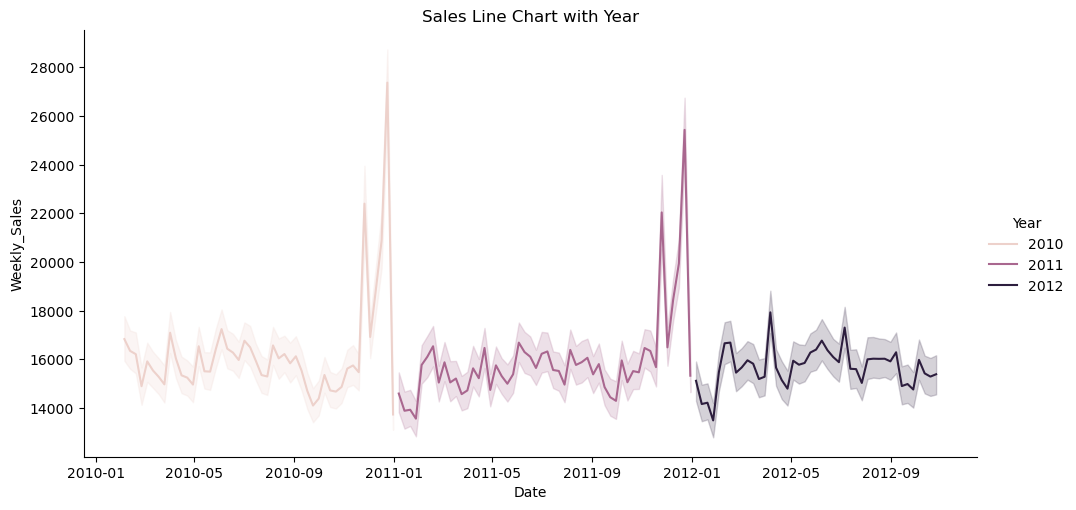

In [10]:
sns.relplot(x='Date',y='Weekly_Sales',hue='Year',data=train_merged, kind='line',aspect=2)
plt.title("Sales Line Chart with Year")
plt.show()

- It can be seen through Line chart that there is no trend in year wise and no random event also happen in any year
- Also it can be seen that at the end of the year there is hufe sales compared to other month whih tells that christmas and thanksgiving has more impact on sales compared to Super Bowl ,Labour Day.

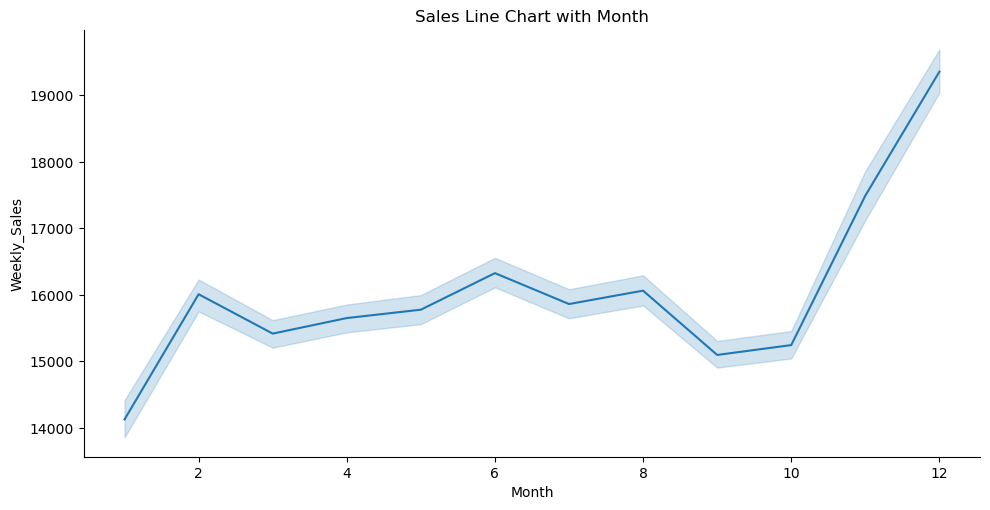

In [11]:
sns.relplot(x='Month',y='Weekly_Sales',data=train_merged, kind='line',aspect=2)
plt.title("Sales Line Chart with Month")
plt.show()

- It can be seen that in november and december sales are very high compared to other month wich tells the impact of thanksgiving and christmas on sales.

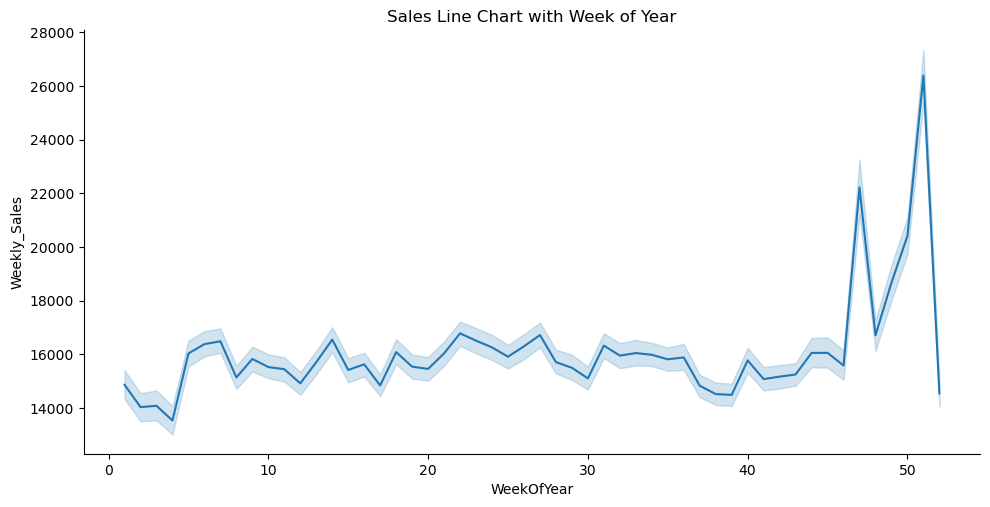

In [12]:
sns.relplot(x='WeekOfYear',y='Weekly_Sales',data=train_merged, kind='line',aspect=2)
plt.title("Sales Line Chart with Week of Year")
plt.show()

- Here Also it can be seen that week 45 to 50 have higher sales where christmas and thanksgiving comes

### Check correlation between categorical features with numerical feature

In [13]:
#This function is creating eta square test
def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = numerator/denominator
    return eta

In [14]:
print("Correlation of Store feature with Weekly_Sales")
print(correlation_ratio(train_merged['Store'],train_merged['Weekly_Sales']))
print(50*'*')
print("Correlation of Department feature with Weekly_Sales")
print(correlation_ratio(train_merged['Dept'],train_merged['Weekly_Sales']))
print(50*'*')
print("Correlation of Type feature with Weekly_Sales")
print(correlation_ratio(train_merged['Type'],train_merged['Weekly_Sales']))
print(50*'*')

Correlation of Store feature with Weekly_Sales
0.09320619110455744
**************************************************
Correlation of Department feature with Weekly_Sales
0.5368007370698533
**************************************************
Correlation of Type feature with Weekly_Sales
0.035527338793980845
**************************************************


- As it can be see that correlation between Department and Weekly_sales is highest.
- Store and Type is Also Correlated

## Correlation of  Numerical feature with Weekly_sales

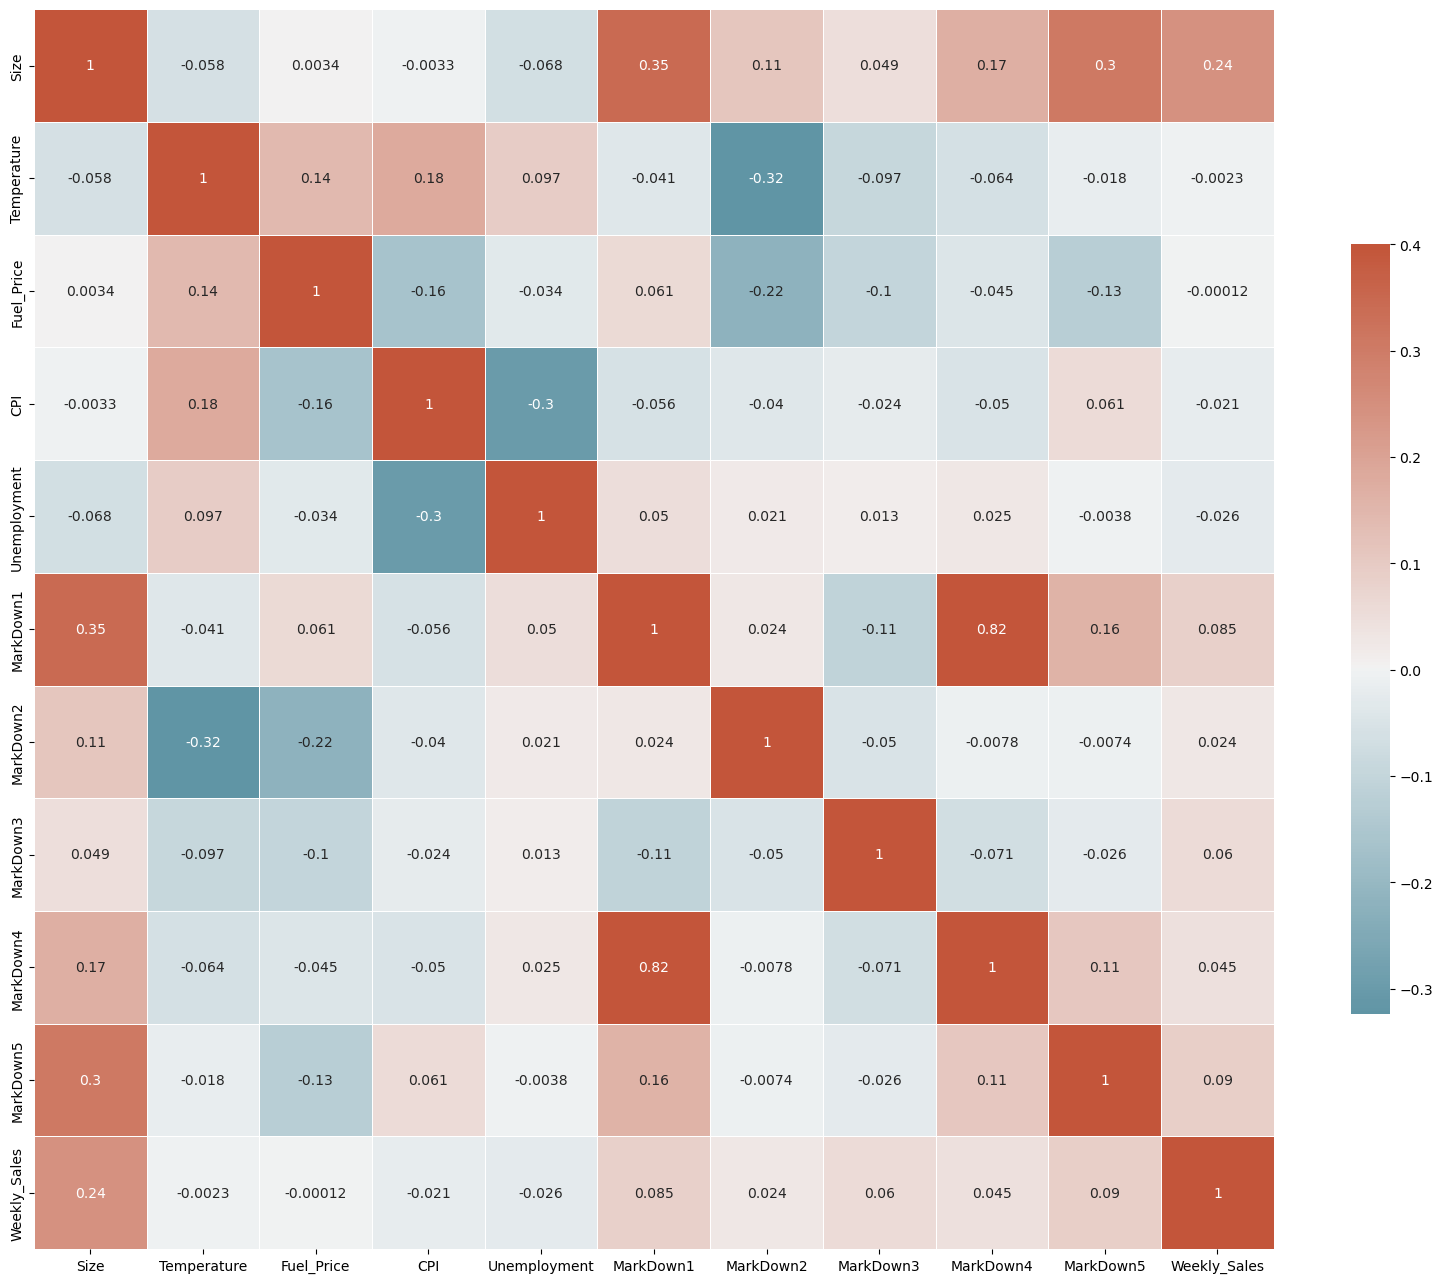

In [15]:
data = pd.concat([train_merged['Size'], train_merged['Temperature'],train_merged['Fuel_Price'],train_merged['CPI'],train_merged['Unemployment'],
                  train_merged['MarkDown1'],train_merged['MarkDown2'],train_merged['MarkDown3'],train_merged['MarkDown4'],
                  train_merged['MarkDown5'],train_merged['Weekly_Sales']], axis=1)
corr = data.corr()
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmax=.4, center=0, annot=True,
                square=True, linewidths=.5, cbar_kws={'shrink': .5})
plt.show()

### Deep into correlation of Store, Dept and Type features with Weekly_Sales

- Popularity of Store Types

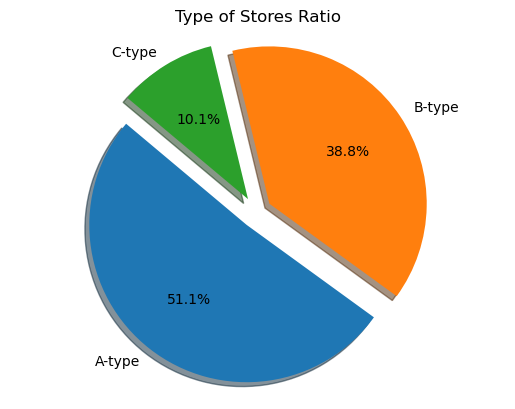

In [16]:
Count_A,Count_B,Count_C = train_merged['Type'].value_counts()
Tasks = [Count_A,Count_B,Count_C]
explode = (0.1, 0.1, 0.1)  # explode 1st slice

i_labels = 'A-type','B-type','C-type'
plt.pie(Tasks,labels=i_labels,autopct='%1.1f%%',explode=explode,shadow=True, startangle=140)
plt.title('Type of Stores Ratio')
plt.axis('equal')
plt.show()

- As it can be seen that there are many stores of A-type and very less stores of C-type

### Type Feature

In [17]:
avgweeklysales = train_merged.groupby('Type')['Weekly_Sales'].mean().to_dict()
df = pd.DataFrame(list(avgweeklysales.items()), columns=['Store_Type', 'AvgSales'])

fig = px.bar(df, 
             x="Store_Type", 
             y="AvgSales",  
             title="Avergae Sales - Per Store Type")
fig.show()

- In terms of sales, type A stores are superior than the other two types
- So we can conclude that type is an important categorical feature to predicting weekly sales. And plays role in increasing sales of a store

### Size feature

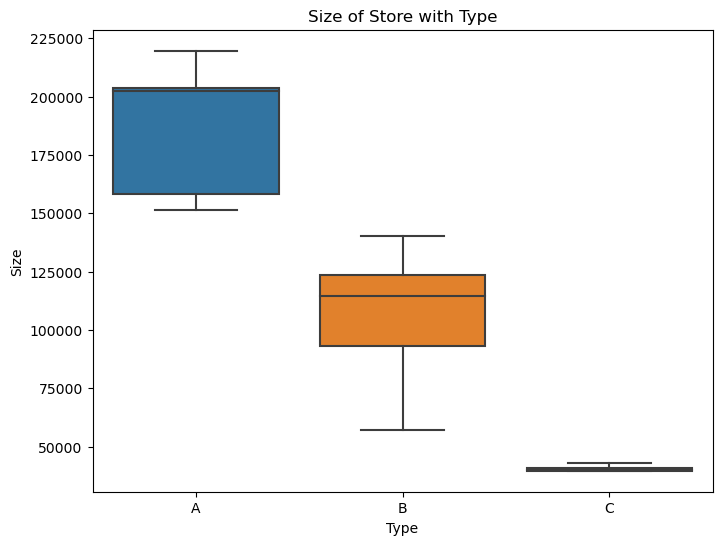

In [18]:
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='Type', y='Size', data=train_merged, showfliers=False)
plt.title('Size of Store with Type')
plt.show()

- from pie chart and box plot, it is showed type A has stires of largest size, then B and finally C

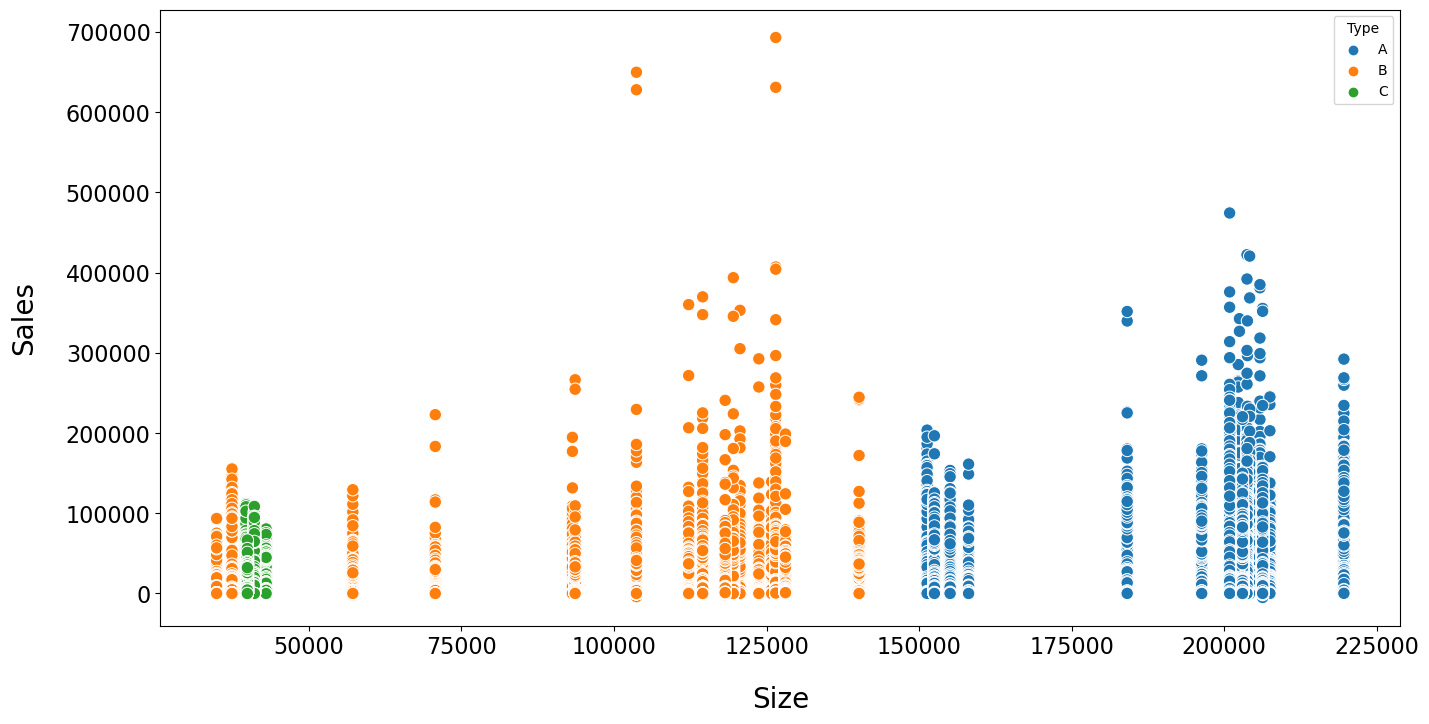

In [19]:
plt.figure(figsize=(16,8))
sns.scatterplot(x=train_merged.Size, y=train_merged.Weekly_Sales, hue=train_merged.Type, s=80);

plt.xticks( fontsize=16)
plt.yticks( fontsize=16)
plt.xlabel('Size', fontsize=20, labelpad=20)
plt.ylabel('Sales', fontsize=20, labelpad=20);

- The size of the store shows a linear relationship with the weekly sales. The sales generally increases with increase of size of store with some exceptions

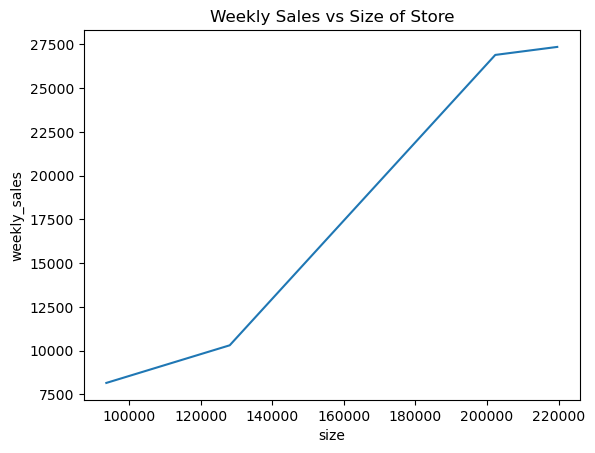

In [20]:
grouped_1=train_merged.groupby('Size')
weekly_sales=list(grouped_1.mean()['Weekly_Sales'])
sq = (grouped_1['Size'].unique())
size = [i[0] for i in list(sq)]
weekly_sales = [x for _,x in sorted(zip(size,weekly_sales))]
size.sort()
sizes = []
for i in range(len(size)):
    if(i+1 == len(size)):
        sizes.append(size[i])
    elif ((i+1)%10==0):
        sizes.append(size[i])
weekly_sale=[]
for i in range(len(size)):
    if(i+1 == len(size)):
        weekly_sale.append(weekly_sales[i])
    elif ((i+1)%10==0):
        weekly_sale.append(weekly_sales[i])
weekly_sales
plt.plot(sizes, weekly_sale)
plt.title('Weekly Sales vs Size of Store')
plt.xlabel('size')
plt.ylabel('weekly_sales')
plt.show()

- through this line chart it can be seen that as size increases, weekly sales also increases.

### Store Feature

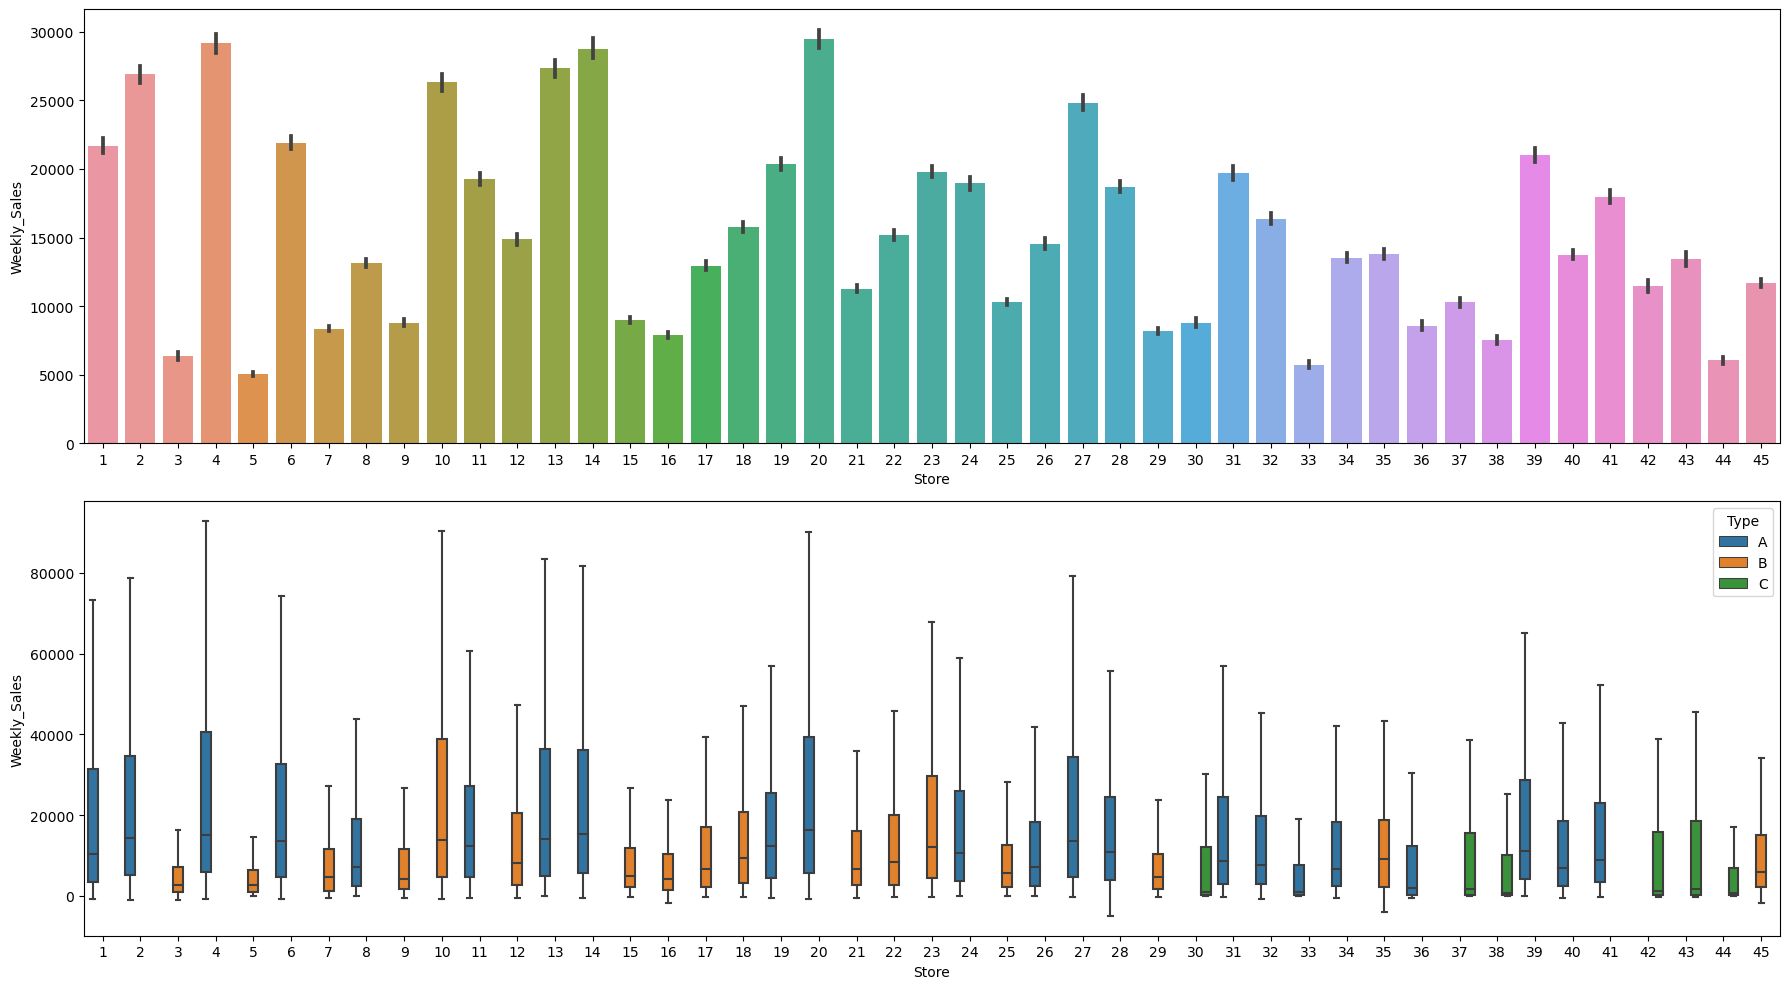

In [21]:
fig, axs = plt.subplots(2,figsize=(18, 10))
sns.barplot(x="Store",y='Weekly_Sales',data=train_merged, ax=axs[0])
sns.boxplot(x="Store",y='Weekly_Sales',data=train_merged,showfliers=False, hue="Type", ax=axs[1])
fig.tight_layout()
plt.show()

1. The sales vary by large amount among the 45 stores


2. It really depends which category of store it is and which week of the particular year is under consideration

##### Avarage sales of store per each year

In [22]:
store_sales_2010 = train_merged[train_merged.Year==2010].groupby('Store')['Weekly_Sales'].mean().to_dict()
store2010_df = pd.DataFrame(list(store_sales_2010.items()), columns=['Store', 'AvgSales2010'])

store_sales_2011 = train_merged[train_merged.Year==2011].groupby('Store')['Weekly_Sales'].mean().to_dict()
store2011_df = pd.DataFrame(list(store_sales_2011.items()), columns=['Store', 'AvgSales2011'])

store_sales_2012 = train_merged[train_merged.Year==2012].groupby('Store')['Weekly_Sales'].mean().to_dict()
store2012_df = pd.DataFrame(list(store_sales_2012.items()), columns=['Store', 'AvgSales2012'])

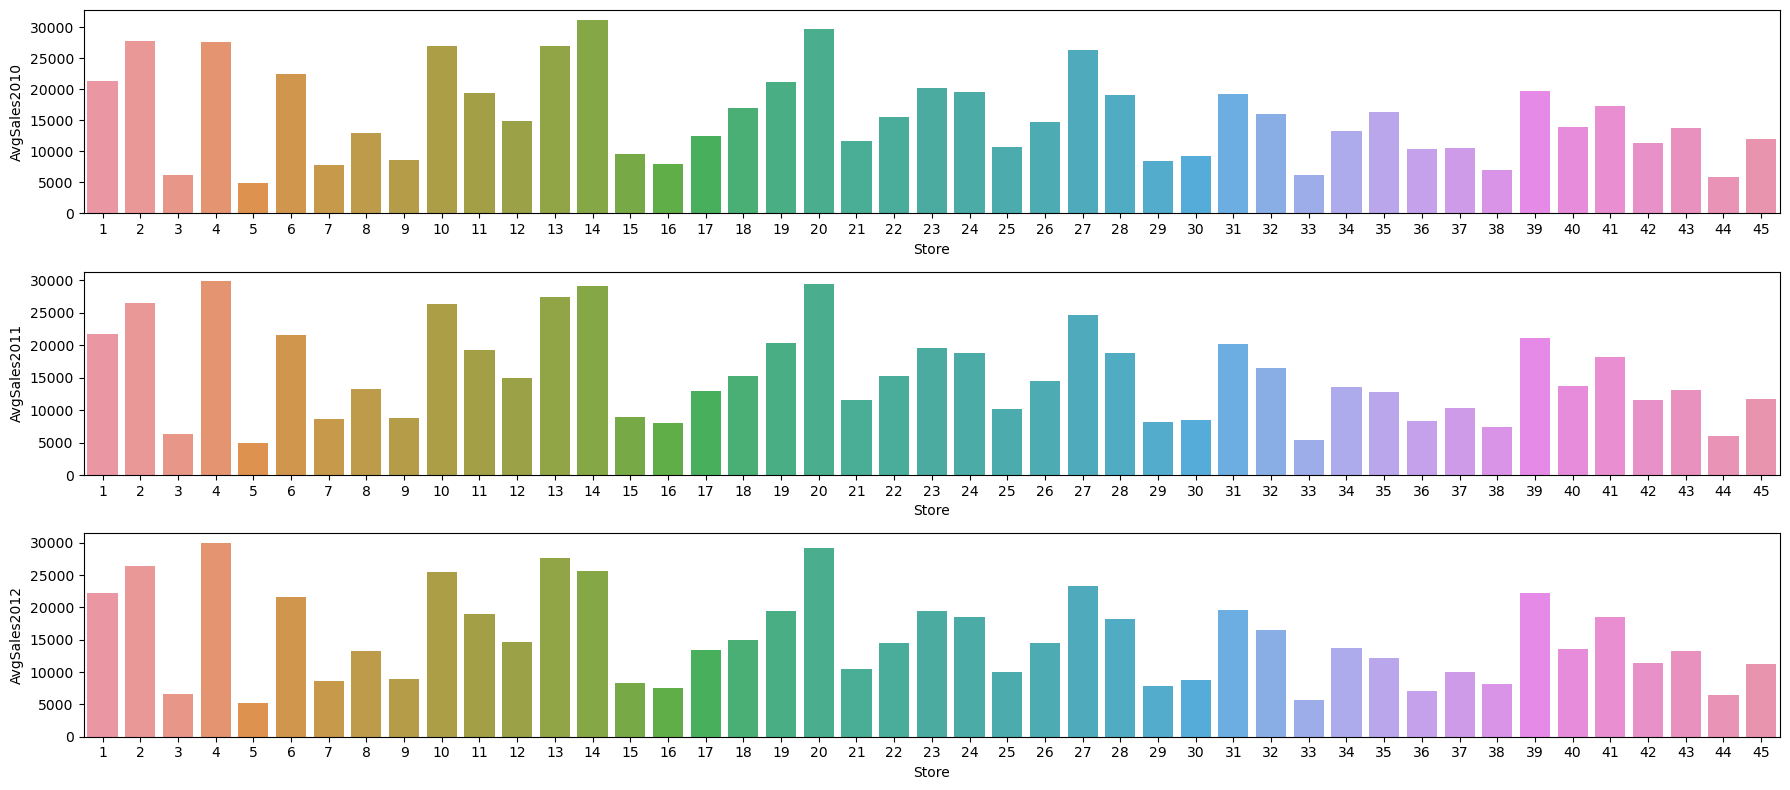

In [23]:
fig, axs = plt.subplots(3,figsize=(18, 8))
sns.barplot(x="Store",y='AvgSales2010',data=store2010_df, ax=axs[0])
sns.barplot(x="Store",y='AvgSales2011',data=store2011_df, ax=axs[1])
sns.barplot(x="Store",y='AvgSales2012',data=store2012_df, ax=axs[2])
fig.tight_layout()
plt.show()

1. The overall trend of store sales over the 3 years remain the same as it depends on the type of store and its size

2. The stores 2,4,13,14 and 20 showed the highest sales in all the 3 years

### Dept feature

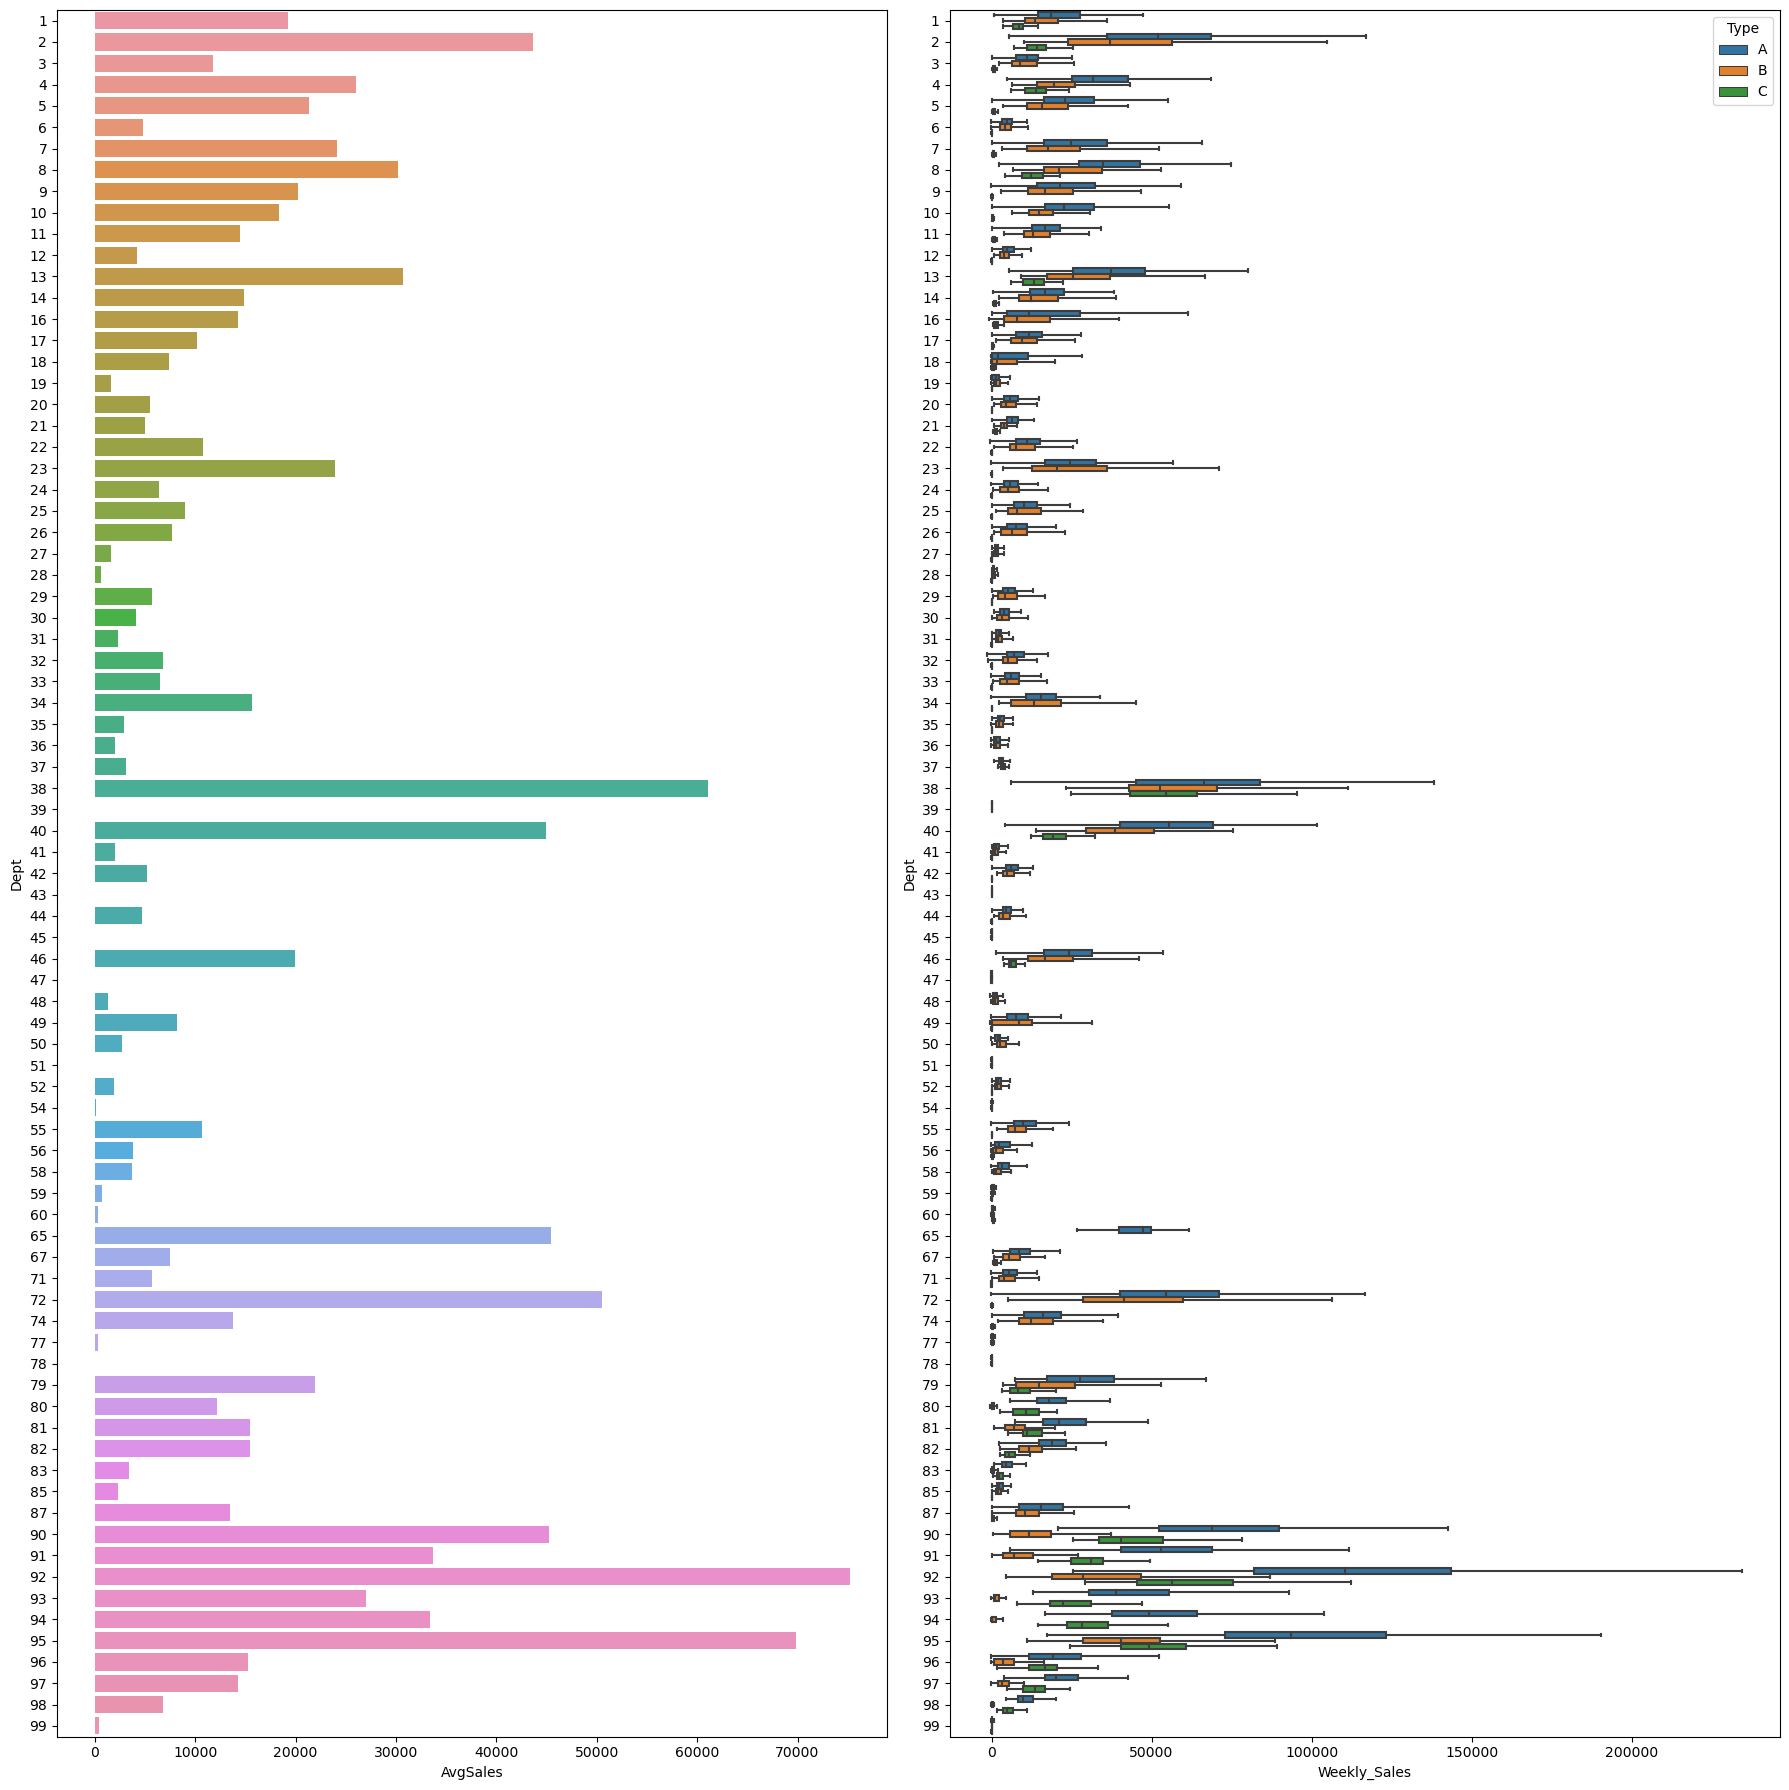

In [24]:
dept_sales = train_merged.groupby('Dept')['Weekly_Sales'].mean().sort_values(ascending=False)
dept_sales = pd.DataFrame(list(dept_sales.items()), columns=['Dept', 'AvgSales'])
fig, axs = plt.subplots(1,2,figsize=(18, 18))
sns.barplot(x="AvgSales",y='Dept',orient='h',data=dept_sales, ax=axs[0])
sns.boxplot(y='Dept', x='Weekly_Sales', data=train_merged, showfliers=False, hue="Type",orient="h", ax=axs[1]) 
fig.tight_layout()
plt.show()

1. Different departments showed different levels of average sales 

2. Notables are 38,65,72,92 and 95 which have highest average sales

3. Department can be a factor in predicting sales as it can be seen through box plot that every department has a different sales than other. Further,  department factor is also correlated with type as it can be seen that type A has higher sales in most of the department.

In [25]:
dept_sales_2010 = train_merged[train_merged.Year==2010].groupby('Dept')['Weekly_Sales'].mean().to_dict()
dept2010_df = pd.DataFrame(list(dept_sales_2010.items()), columns=['Dept', 'AvgSales2010'])

dept_sales_2011 = train_merged[train_merged.Year==2011].groupby('Dept')['Weekly_Sales'].mean().to_dict()
dept2011_df = pd.DataFrame(list(dept_sales_2011.items()), columns=['Dept', 'AvgSales2011'])

dept_sales_2012 = train_merged[train_merged.Year==2012].groupby('Dept')['Weekly_Sales'].mean().to_dict()
dept2012_df = pd.DataFrame(list(dept_sales_2012.items()), columns=['Dept', 'AvgSales2012'])

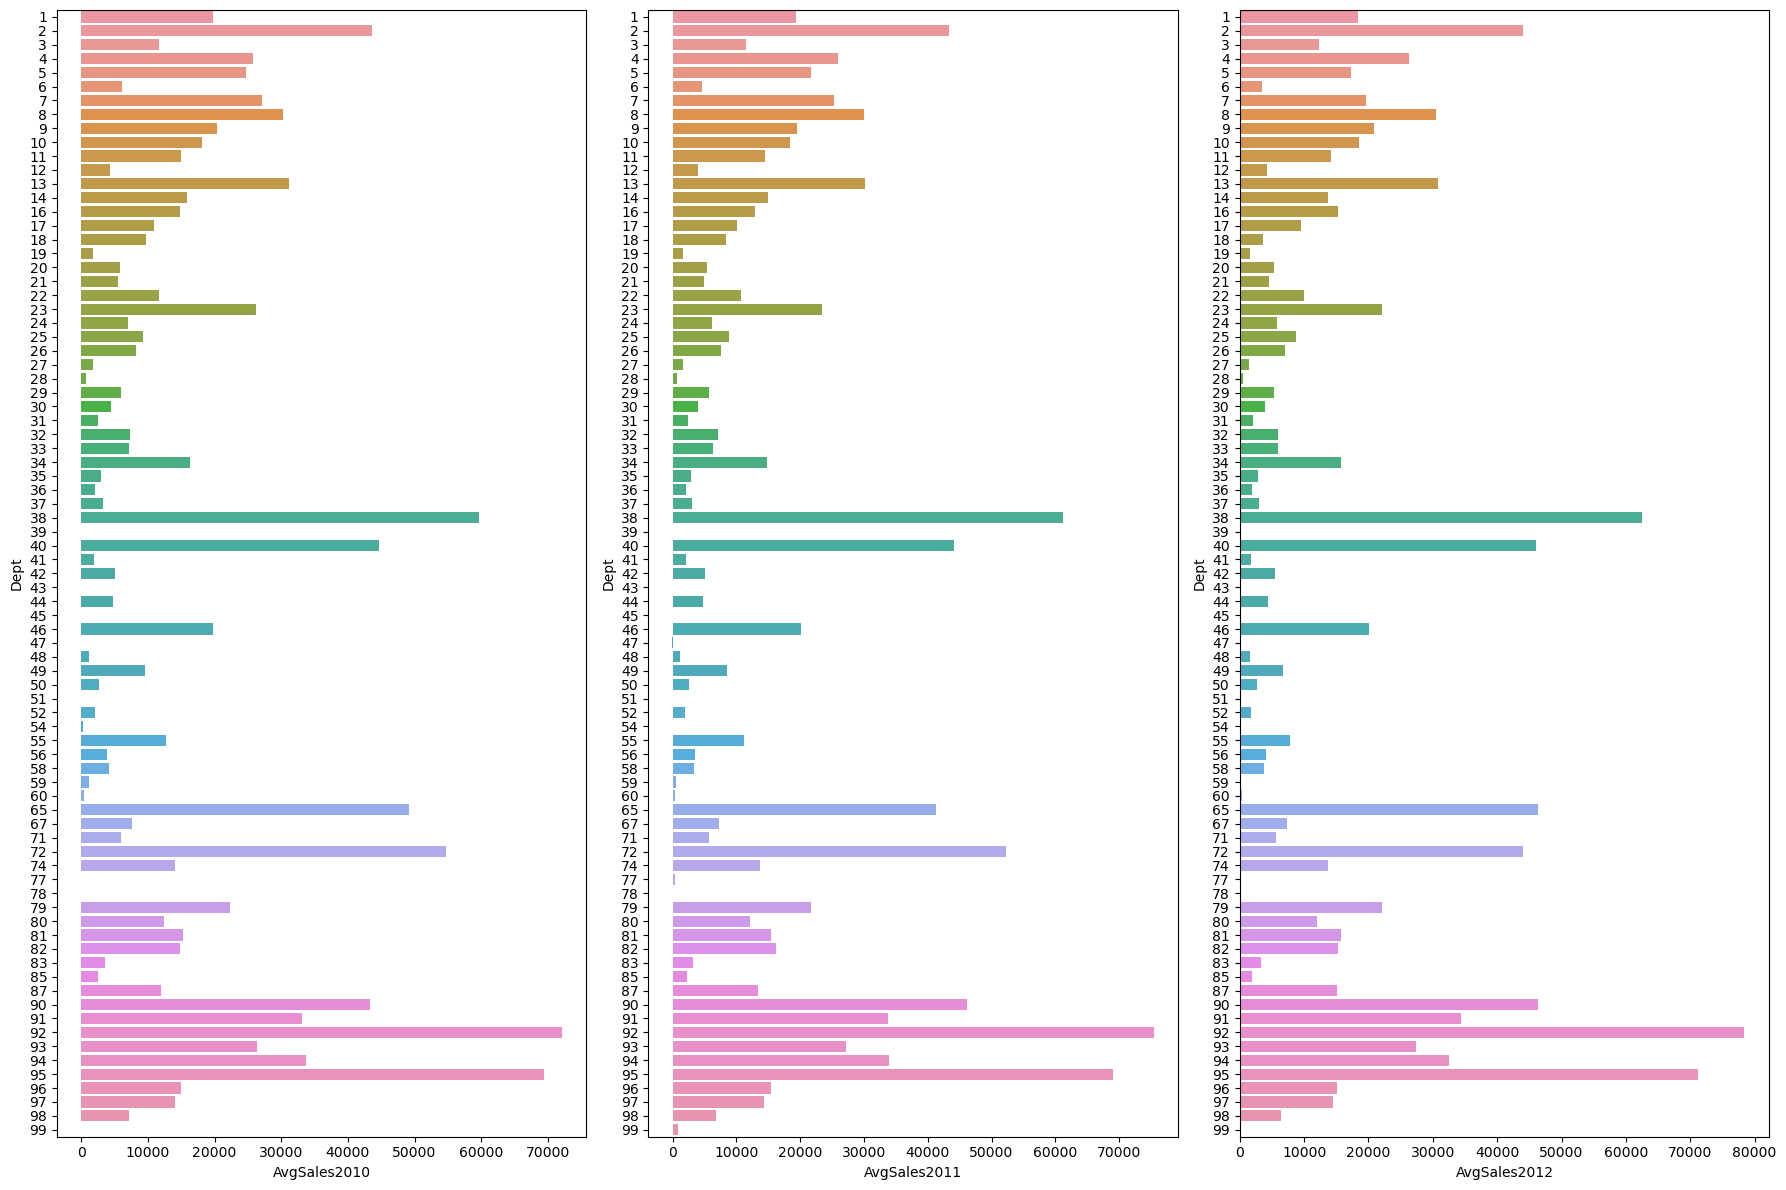

In [26]:
fig, axs = plt.subplots(1,3, figsize=(18, 12))
sns.barplot(y="Dept",x='AvgSales2010',data=dept2010_df,orient='h', ax=axs[0])
sns.barplot(y="Dept",x='AvgSales2011',data=dept2011_df,orient='h', ax=axs[1])
sns.barplot(y="Dept",x='AvgSales2012',data=dept2012_df,orient='h', ax=axs[2])
fig.tight_layout()
plt.show()

 The sales trend on yearly basis remain the same. Stores with higher sales appeared in all the 3 years while with lowe sales showed the same trend in all the 3 years

### Holidays Vs Nonholidays Sales

In [27]:
holiday_sales = train_merged.groupby('IsHoliday')['Weekly_Sales'].mean()
holiday_sales_df = pd.DataFrame(list(holiday_sales.items()), columns=['IsHoliday', 'AvgSales'])
holiday_counts = train_merged.IsHoliday.value_counts()
holiday_counts_df = pd.DataFrame(holiday_counts).reset_index()
holiday_counts_df.columns = ['IsHoliday', 'Counts']

In [28]:
train_merged.IsHoliday.value_counts()

False    391909
True      29661
Name: IsHoliday, dtype: int64

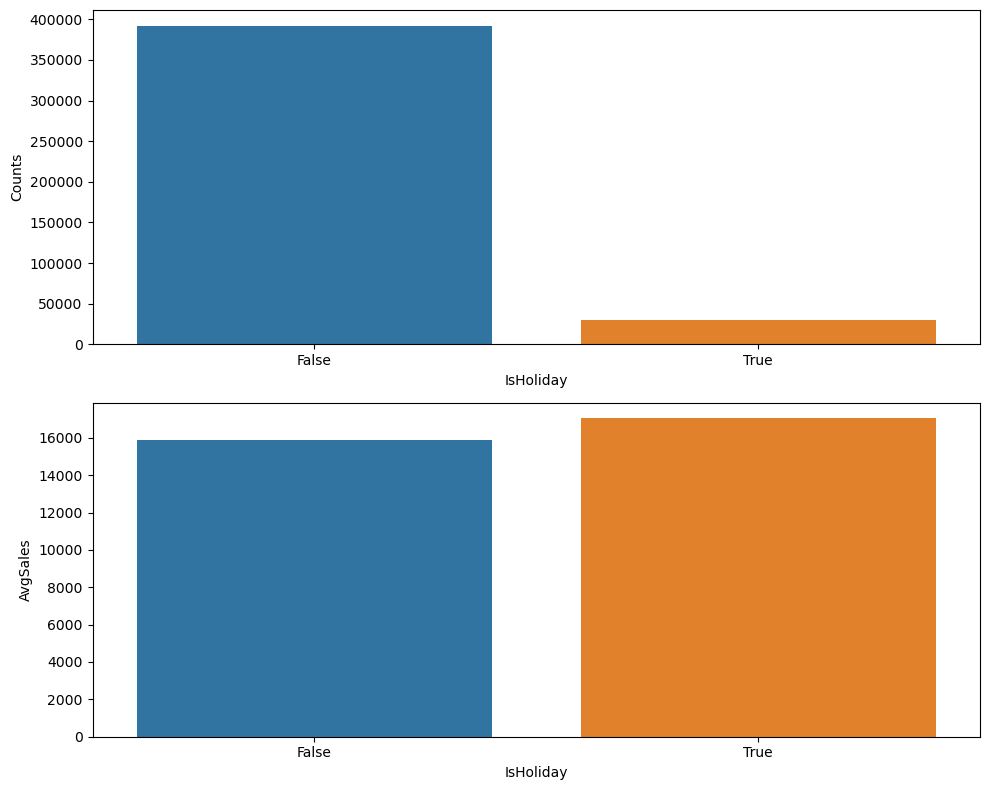

In [29]:
fig, axs = plt.subplots(2, figsize=(10, 8))
sns.barplot(x="IsHoliday",y='Counts',data=holiday_counts_df, ax=axs[0])
sns.barplot(x="IsHoliday",y='AvgSales',data=holiday_sales_df, ax=axs[1])
fig.tight_layout()
plt.show()

1. Only 7 percent of the weeks in the data are the holiday weeks


2. Despite being the less peecentage of holiday weeks the sales in the holidays week are on the average higher than in the non-holiday weeks

In [63]:
dates =[]
for ptr in holidays.US(years = 2010).items():
    dates.append(ptr[0])
for ptr in holidays.US(years = 2011).items():
    dates.append(ptr[0])
for ptr in holidays.US(years = 2012).items():
    dates.append(ptr[0])
holidays_list=[] 
for index, row in train.iterrows():
    dat = train_merged['Date'][index]
    dt=[]
    for i in range(0,5):
        dt.append(dat - datetime.timedelta(days = i))
    for i in range(1,3):
        dt.append(dat + datetime.timedelta(days = i))
    count = 0
    for date in dates:
        if date in dt:
            count +=1
    holidays_list.append(count)
    
train_merged['Holidays'] = np.array(holidays_list)

KeyboardInterrupt: 

In [62]:
train_merged[train_merged['Holidays'] == 1]

Store  Dept       Date  Weekly_Sales  IsHoliday Type    Size  \
2           1     1 2010-02-19      41595.55      False    A  151315   
17          1     1 2010-06-04      17558.09      False    A  151315   
21          1     1 2010-07-02      16333.14      False    A  151315   
22          1     1 2010-07-09      17688.76      False    A  151315   
31          1     1 2010-09-10      18194.74       True    A  151315   
...       ...   ...        ...           ...        ...  ...     ...   
421534     45    98 2012-02-24        544.34      False    B  118221   
421548     45    98 2012-06-01        874.64      False    B  118221   
421553     45    98 2012-07-06        659.65      False    B  118221   
421562     45    98 2012-09-07        352.44       True    B  118221   
421567     45    98 2012-10-12       1061.02      False    B  118221   

        Temperature  Fuel_Price  MarkDown1  ...  MarkDown5         CPI  \
2             39.93       2.514        NaN  ...        NaN  211.289143   
17            80.69       2.705        NaN  ...        NaN  211.176428   
21            80.91       2.669        NaN  ...        NaN  211.223533   
22            80.48       2.642        NaN  ...        NaN  211.108414   
31            78.69       2.565        NaN  ...        NaN  211.495190   
...             ...         ...        ...  ...        ...         ...   
421534        42.86       3.739    9006.21  ...    7626.46  190.006988   
421548        74.48       3.742   10643.62  ...    1856.97  191.009171   
421553        82.99       3.475    5878.09  ...    5477.04  191.133883   
421562        75.70       3.911   11024.45  ...    2055.70  191.577676   
421567        54.47       4.000    1956.28  ...    3990.54  192.327265   

        Unemployment  Year  Month  Day  WeekOfYear  n_days  Holidays  \
2              8.106  2010      2   19         7.0      14         1   
17             7.808  2010      6    4        22.0     119         1   
21             7.787  2010      7    2        26.0     147         1   
22             7.787  2010      7    9        27.0     154         1   
31             7.787  2010      9   10        36.0     217         1   
...              ...   ...    ...  ...         ...     ...       ...   
421534         8.424  2012      2   24         8.0     749         1   
421548         8.567  2012      6    1        22.0     847         1   
421553         8.684  2012      7    6        27.0     882         1   
421562         8.684  2012      9    7        36.0     945         1   
421567         8.667  2012     10   12        41.0     980         1   

        Type_Numeric  
2                  3  
17                 3  
21                 3  
22                 3  
31                 3  
...              ...  
421534             2  
421548             2  
421553             2  
421562             2  
421567             2  

[70813 rows x 23 columns]

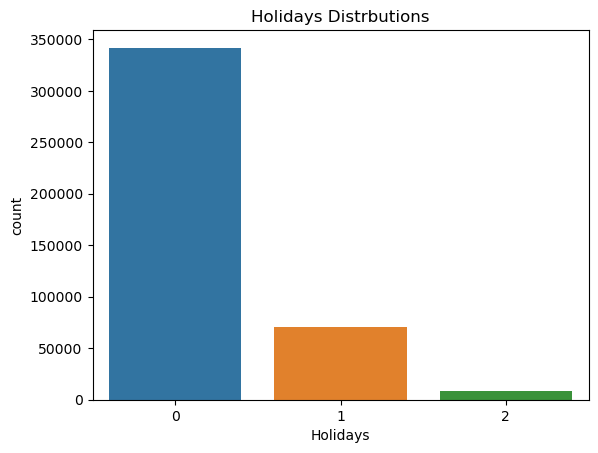

In [31]:
sns.countplot(train_merged['Holidays']);
plt.title("Holidays Distrbutions")
plt.show()

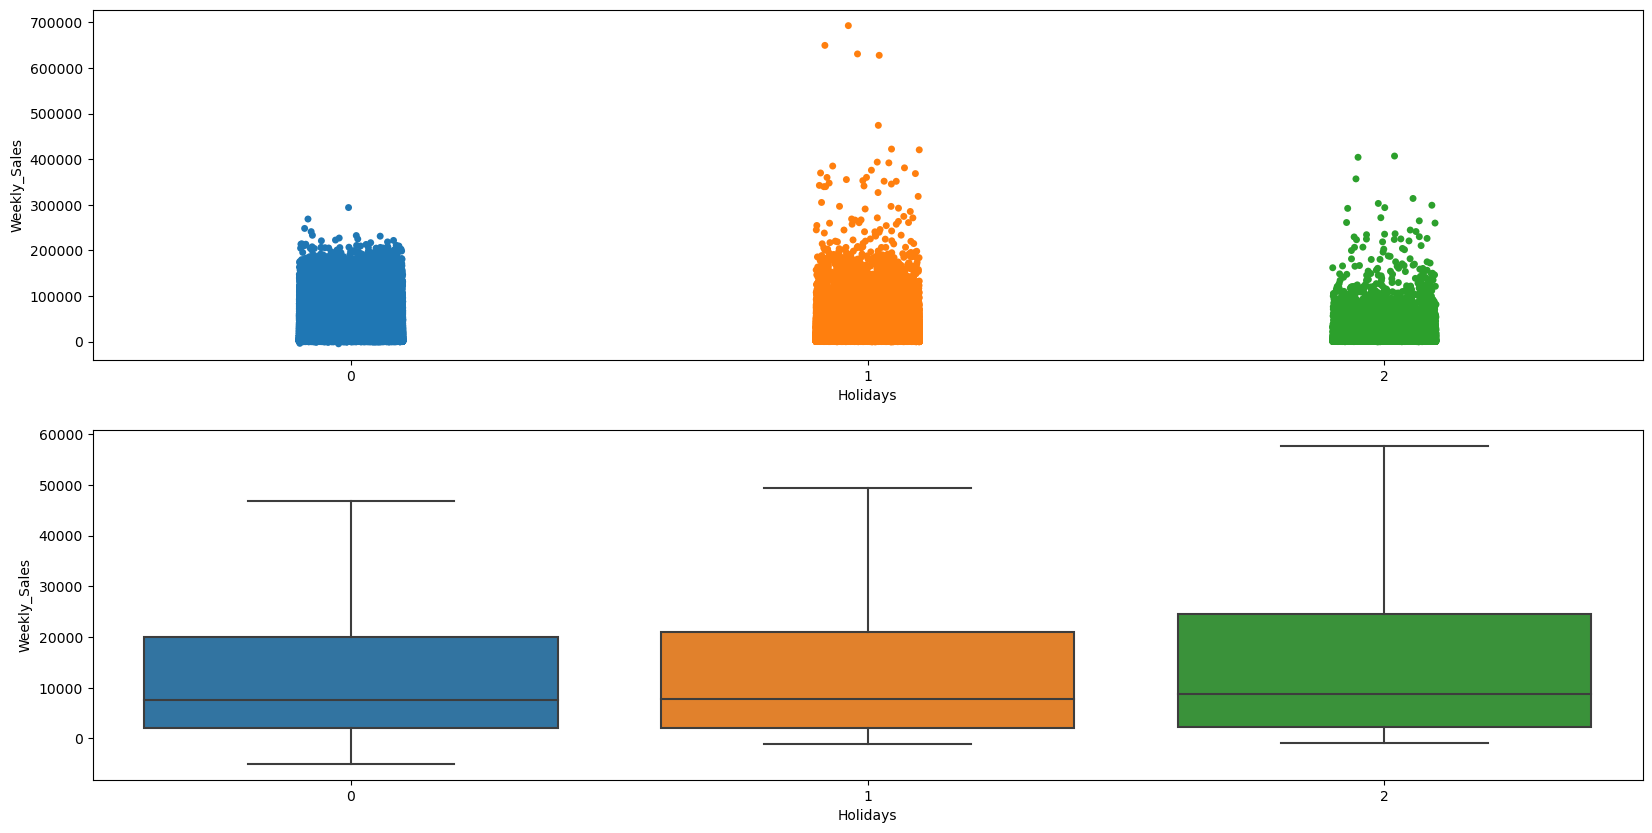

In [32]:
fig, axs = plt.subplots(2,figsize=(20, 10))
sns.stripplot(y=train_merged['Weekly_Sales'], x=train_merged['Holidays'], ax=axs[0])
sns.boxplot(x='Holidays', y='Weekly_Sales', data=train_merged, showfliers=False, ax=axs[1])
plt.show()

- most of the week have no holidays. 
- When Holidays are two in  a week then weekly_sales are bit higher

### Temperature 

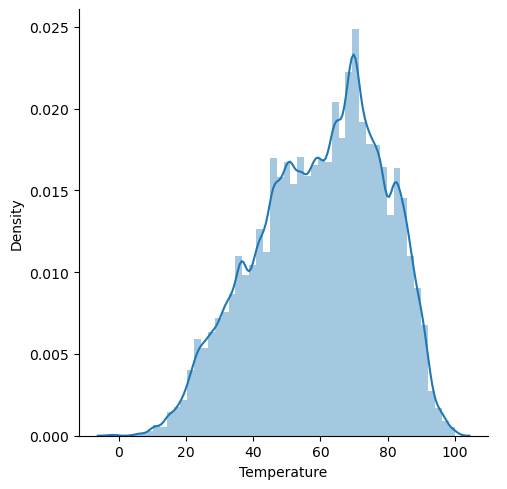

In [33]:
grid4 = sns.FacetGrid(train_merged,size=5).map(sns.distplot,"Temperature").add_legend();
plt.show()

- through here it can be seen that most of the data point lies in 60-80 F temperatures

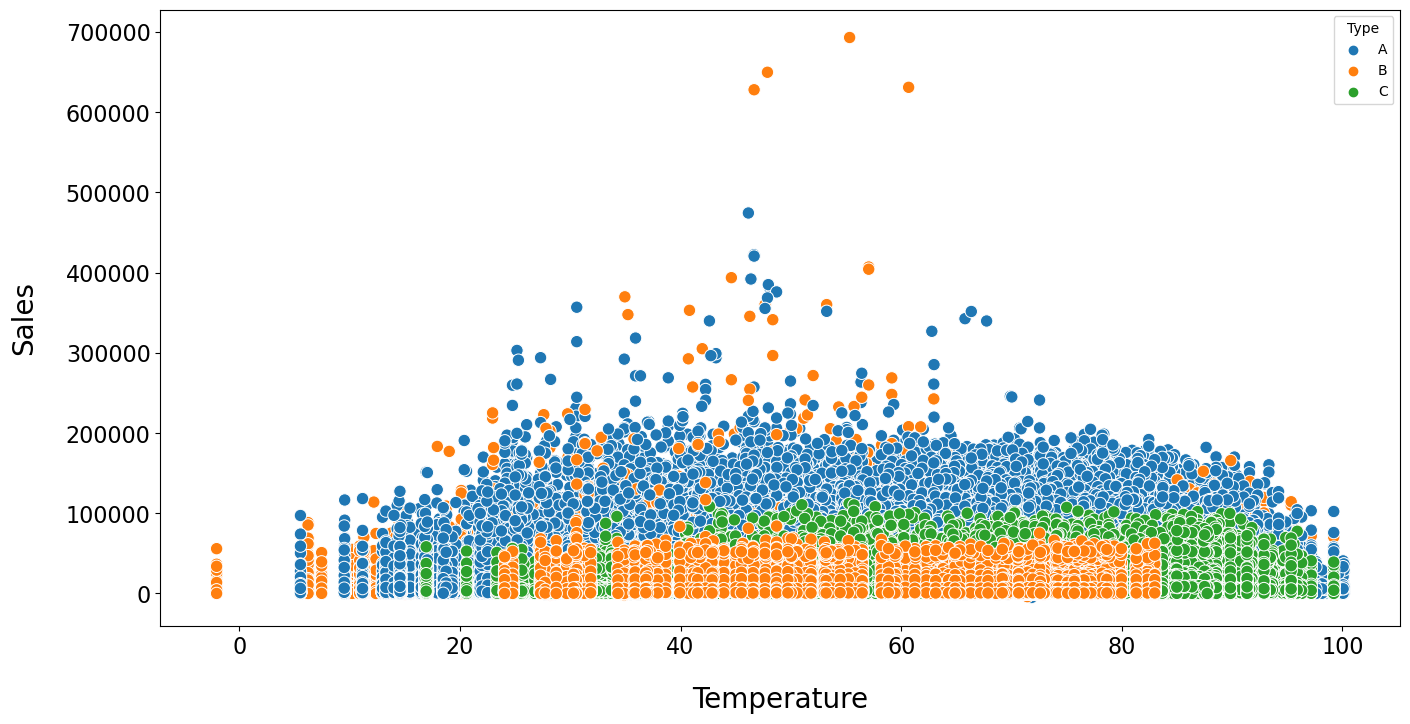

In [34]:
plt.figure(figsize=(16,8))
sns.scatterplot(x=train_merged.Temperature, y=train_merged.Weekly_Sales, hue=train_merged.Type, s=80);

plt.xticks( fontsize=16)
plt.yticks( fontsize=16)
plt.xlabel('Temperature', fontsize=20, labelpad=20)
plt.ylabel('Sales', fontsize=20, labelpad=20);

There seems to be no relatiobship between the temperature in the region and weekly sales of the stores. At low and very high temperatures the sales seems to dip a bit but in general there doesn't exist a clear relationship

### Fuel Price

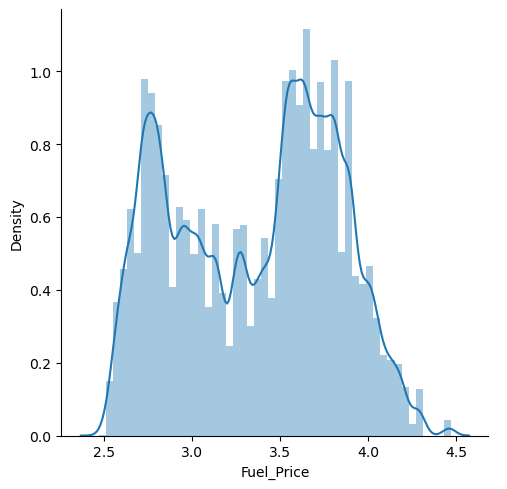

In [35]:
grid33 = sns.FacetGrid(train_merged,size=5).map(sns.distplot,"Fuel_Price").add_legend();
plt.show()

- Here it looks no of datapoints are higher when fuel rate was between 3.5 to 4.0 and 2.5-3.0 .

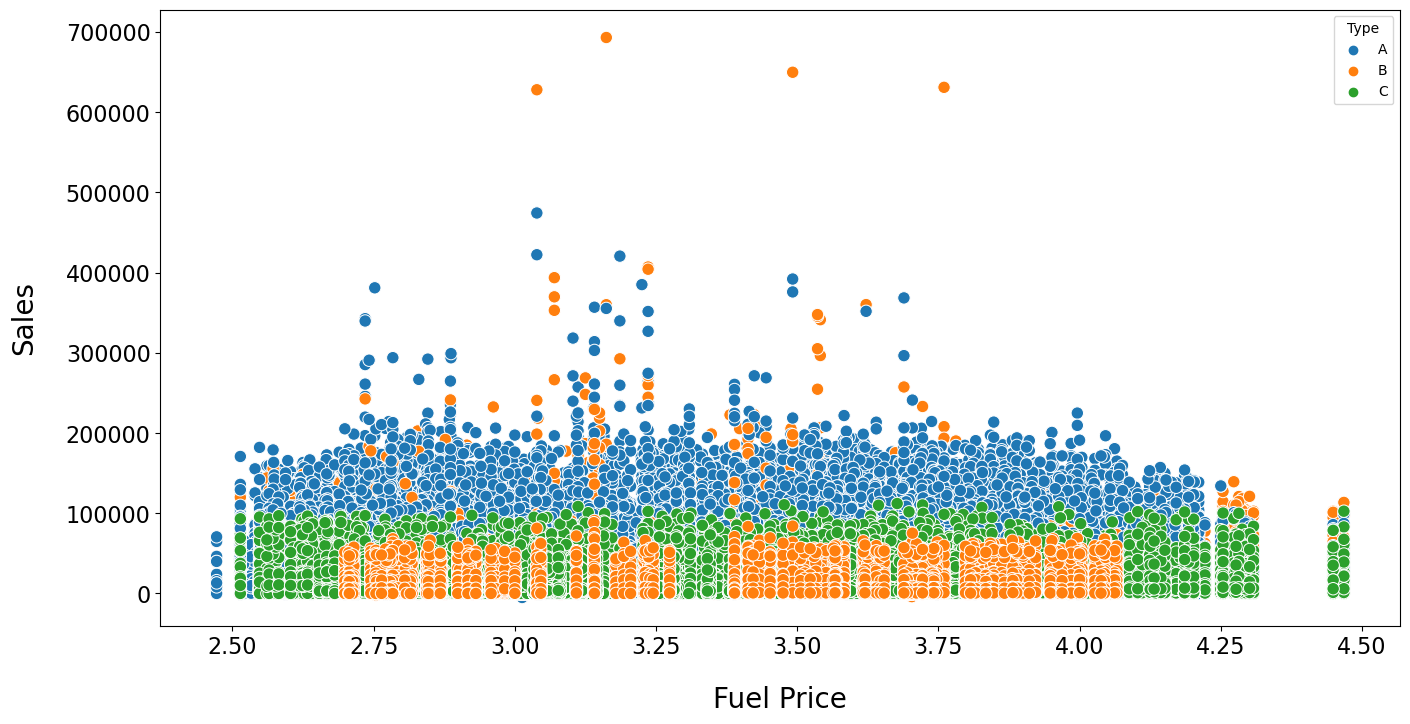

In [36]:
plt.figure(figsize=(16,8))
sns.scatterplot(x=train_merged.Fuel_Price, y=train_merged.Weekly_Sales, hue=train_merged.Type, s=80);

plt.xticks( fontsize=16)
plt.yticks( fontsize=16)
plt.xlabel('Fuel Price', fontsize=20, labelpad=20)
plt.ylabel('Sales', fontsize=20, labelpad=20);

Between fuel price and the sales there doesn't seem to exist any clear relationship

### CPI feature

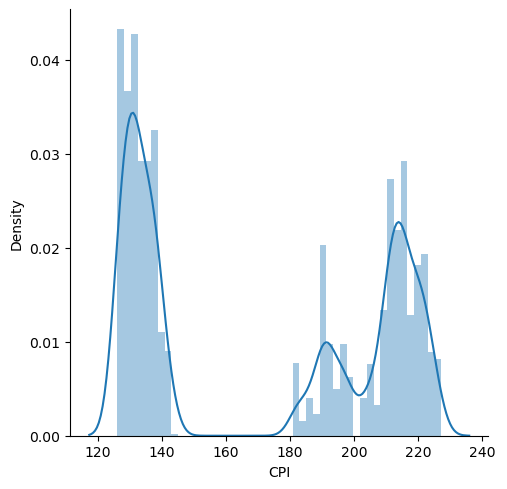

In [37]:
grid = sns.FacetGrid(train_merged,size = 5).map(sns.distplot,"CPI").add_legend();
plt.show()

- between 150 to 170  value of CPI there is no datapoint.

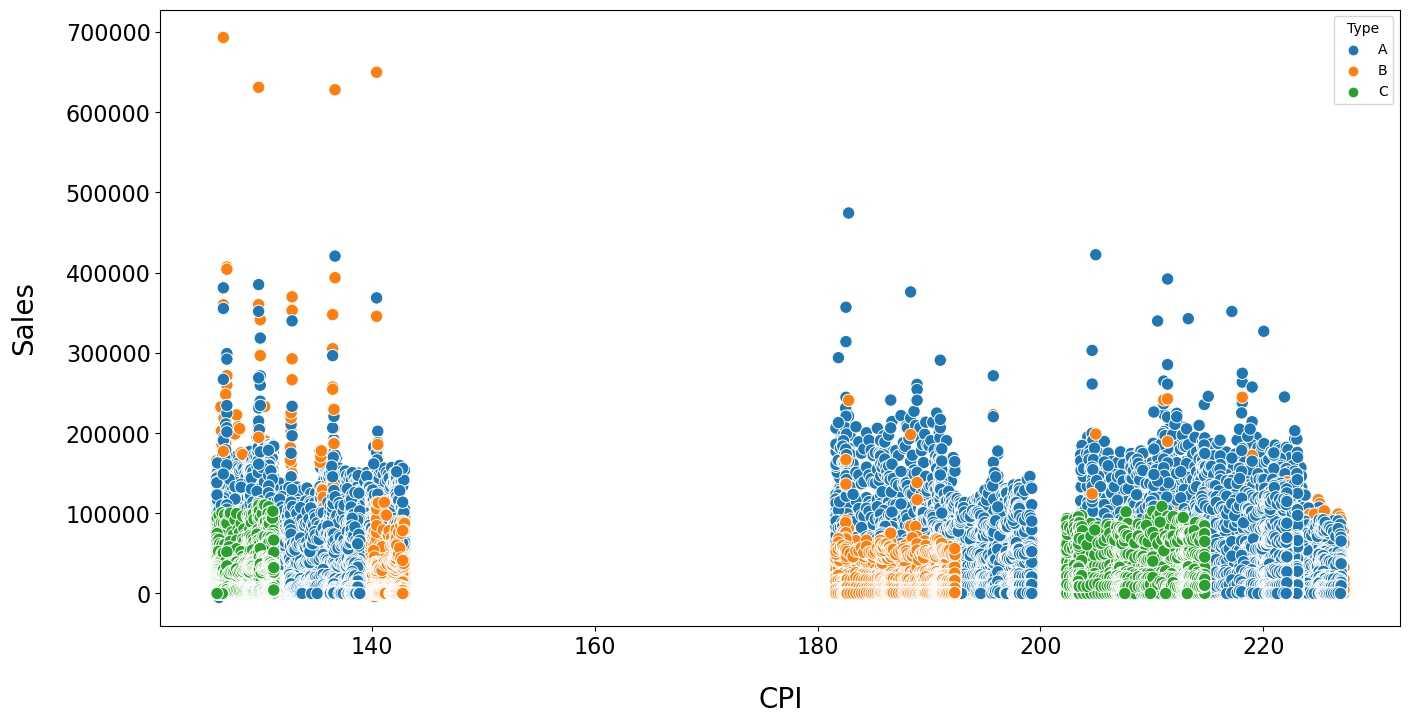

In [38]:
plt.figure(figsize=(16,8))
sns.scatterplot(x=train_merged.CPI, y=train_merged.Weekly_Sales, hue=train_merged.Type, s=80);

plt.xticks( fontsize=16)
plt.yticks( fontsize=16)
plt.xlabel('CPI', fontsize=20, labelpad=20)
plt.ylabel('Sales', fontsize=20, labelpad=20);

There are 3 clear clusters but there doesn't exist any clear correlation between CPI and weekly sales

### Unemployment feature

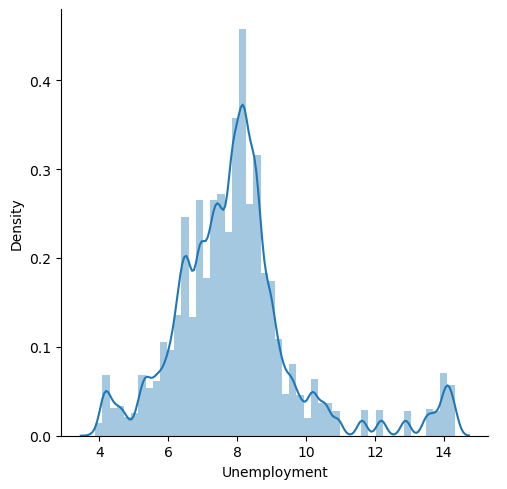

In [39]:
grid2 = sns.FacetGrid(train_merged,size=5).map(sns.distplot,"Unemployment").add_legend()
plt.show()

- Most of the point lies when umployement rate is 8.

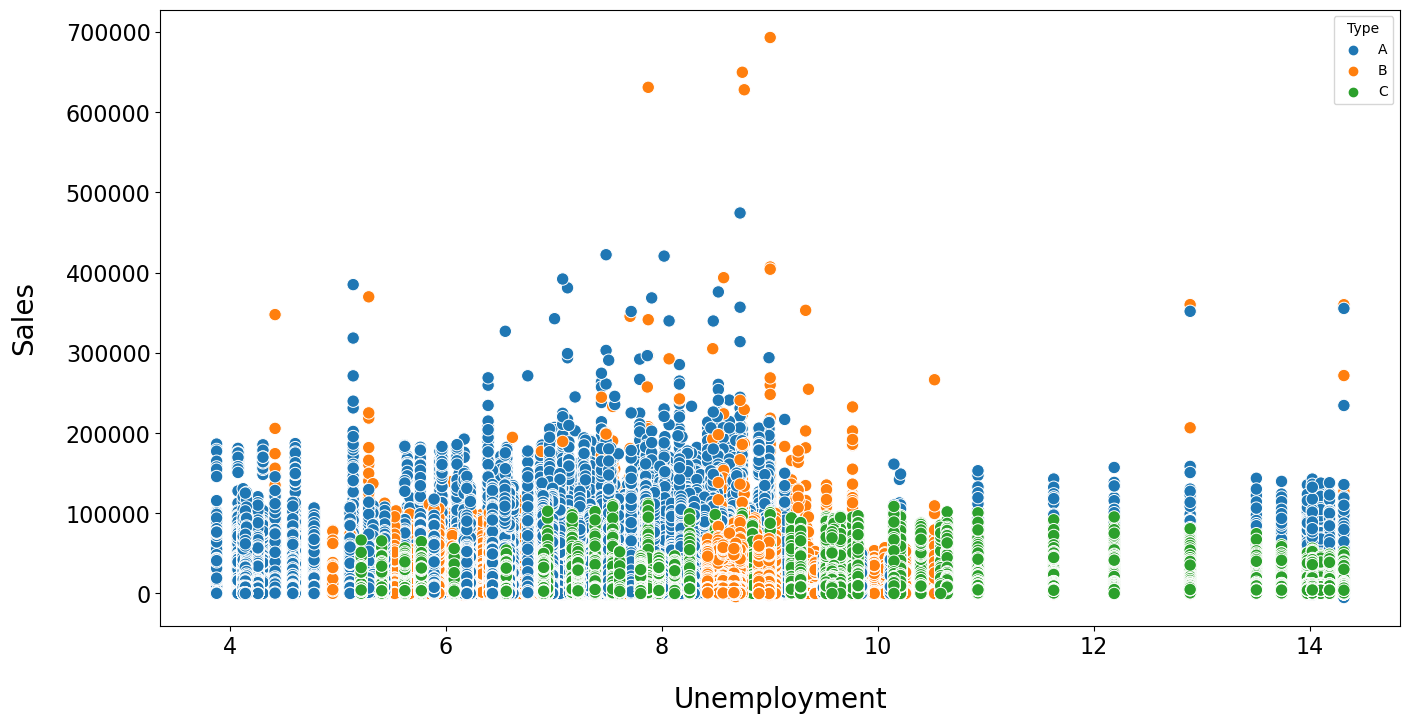

In [40]:
plt.figure(figsize=(16,8))
sns.scatterplot(x=train_merged.Unemployment, y=train_merged.Weekly_Sales, hue=train_merged.Type, s=80);

plt.xticks( fontsize=16)
plt.yticks( fontsize=16)
plt.xlabel('Unemployment', fontsize=20, labelpad=20)
plt.ylabel('Sales', fontsize=20, labelpad=20);

Also the Unemployment rate doesn't seem to have any effect on the weekly sales

## MarkDown features

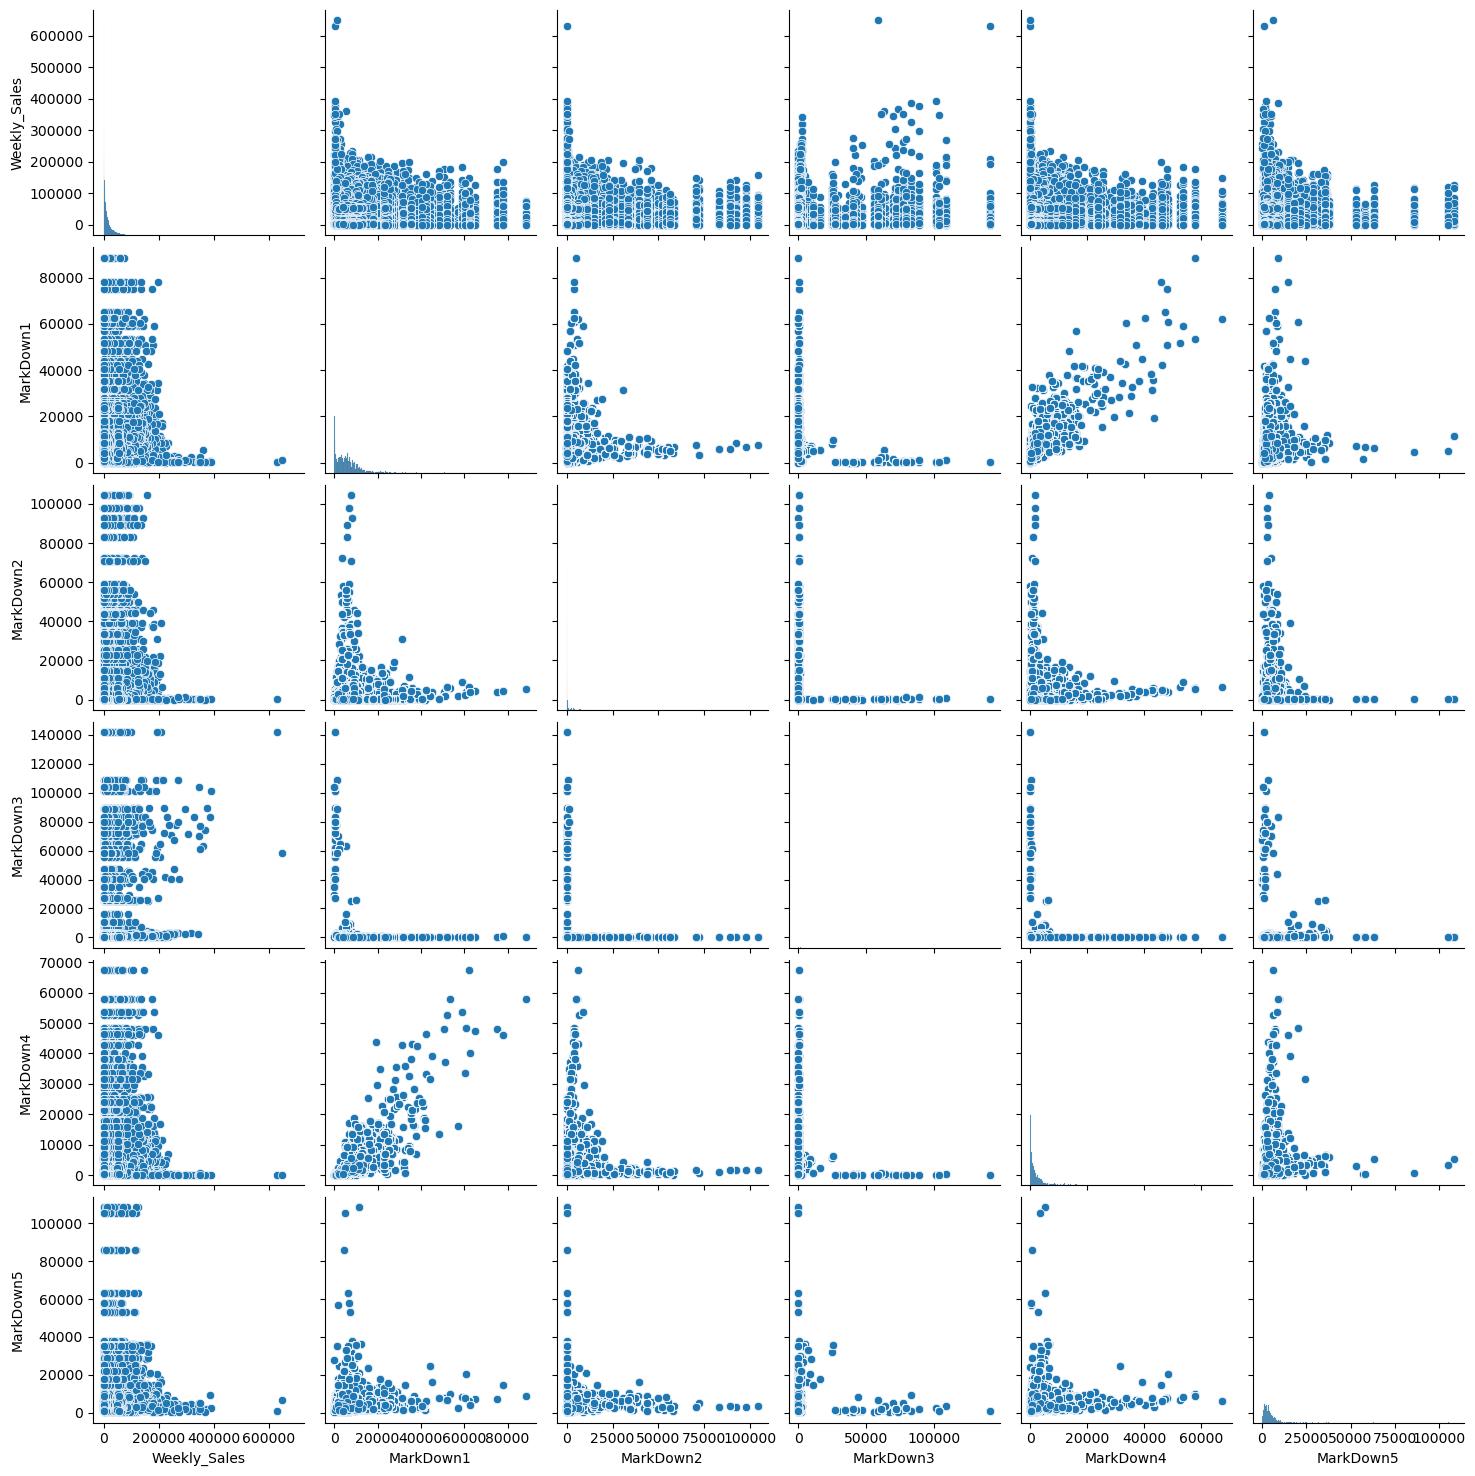

In [41]:
pair = sns.pairplot(train_merged,vars=['Weekly_Sales', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'])
plt.show()

- Markdown 1 and markdown 4 are correlated to some extent

## Coorelation Matrix

In [42]:
storetype_values = {'A':3, 'B':2, 'C':1}
train_merged['Type_Numeric'] = train_merged.Type.map(storetype_values)
test_merged['Type_Numeric'] = test_merged.Type.map(storetype_values)

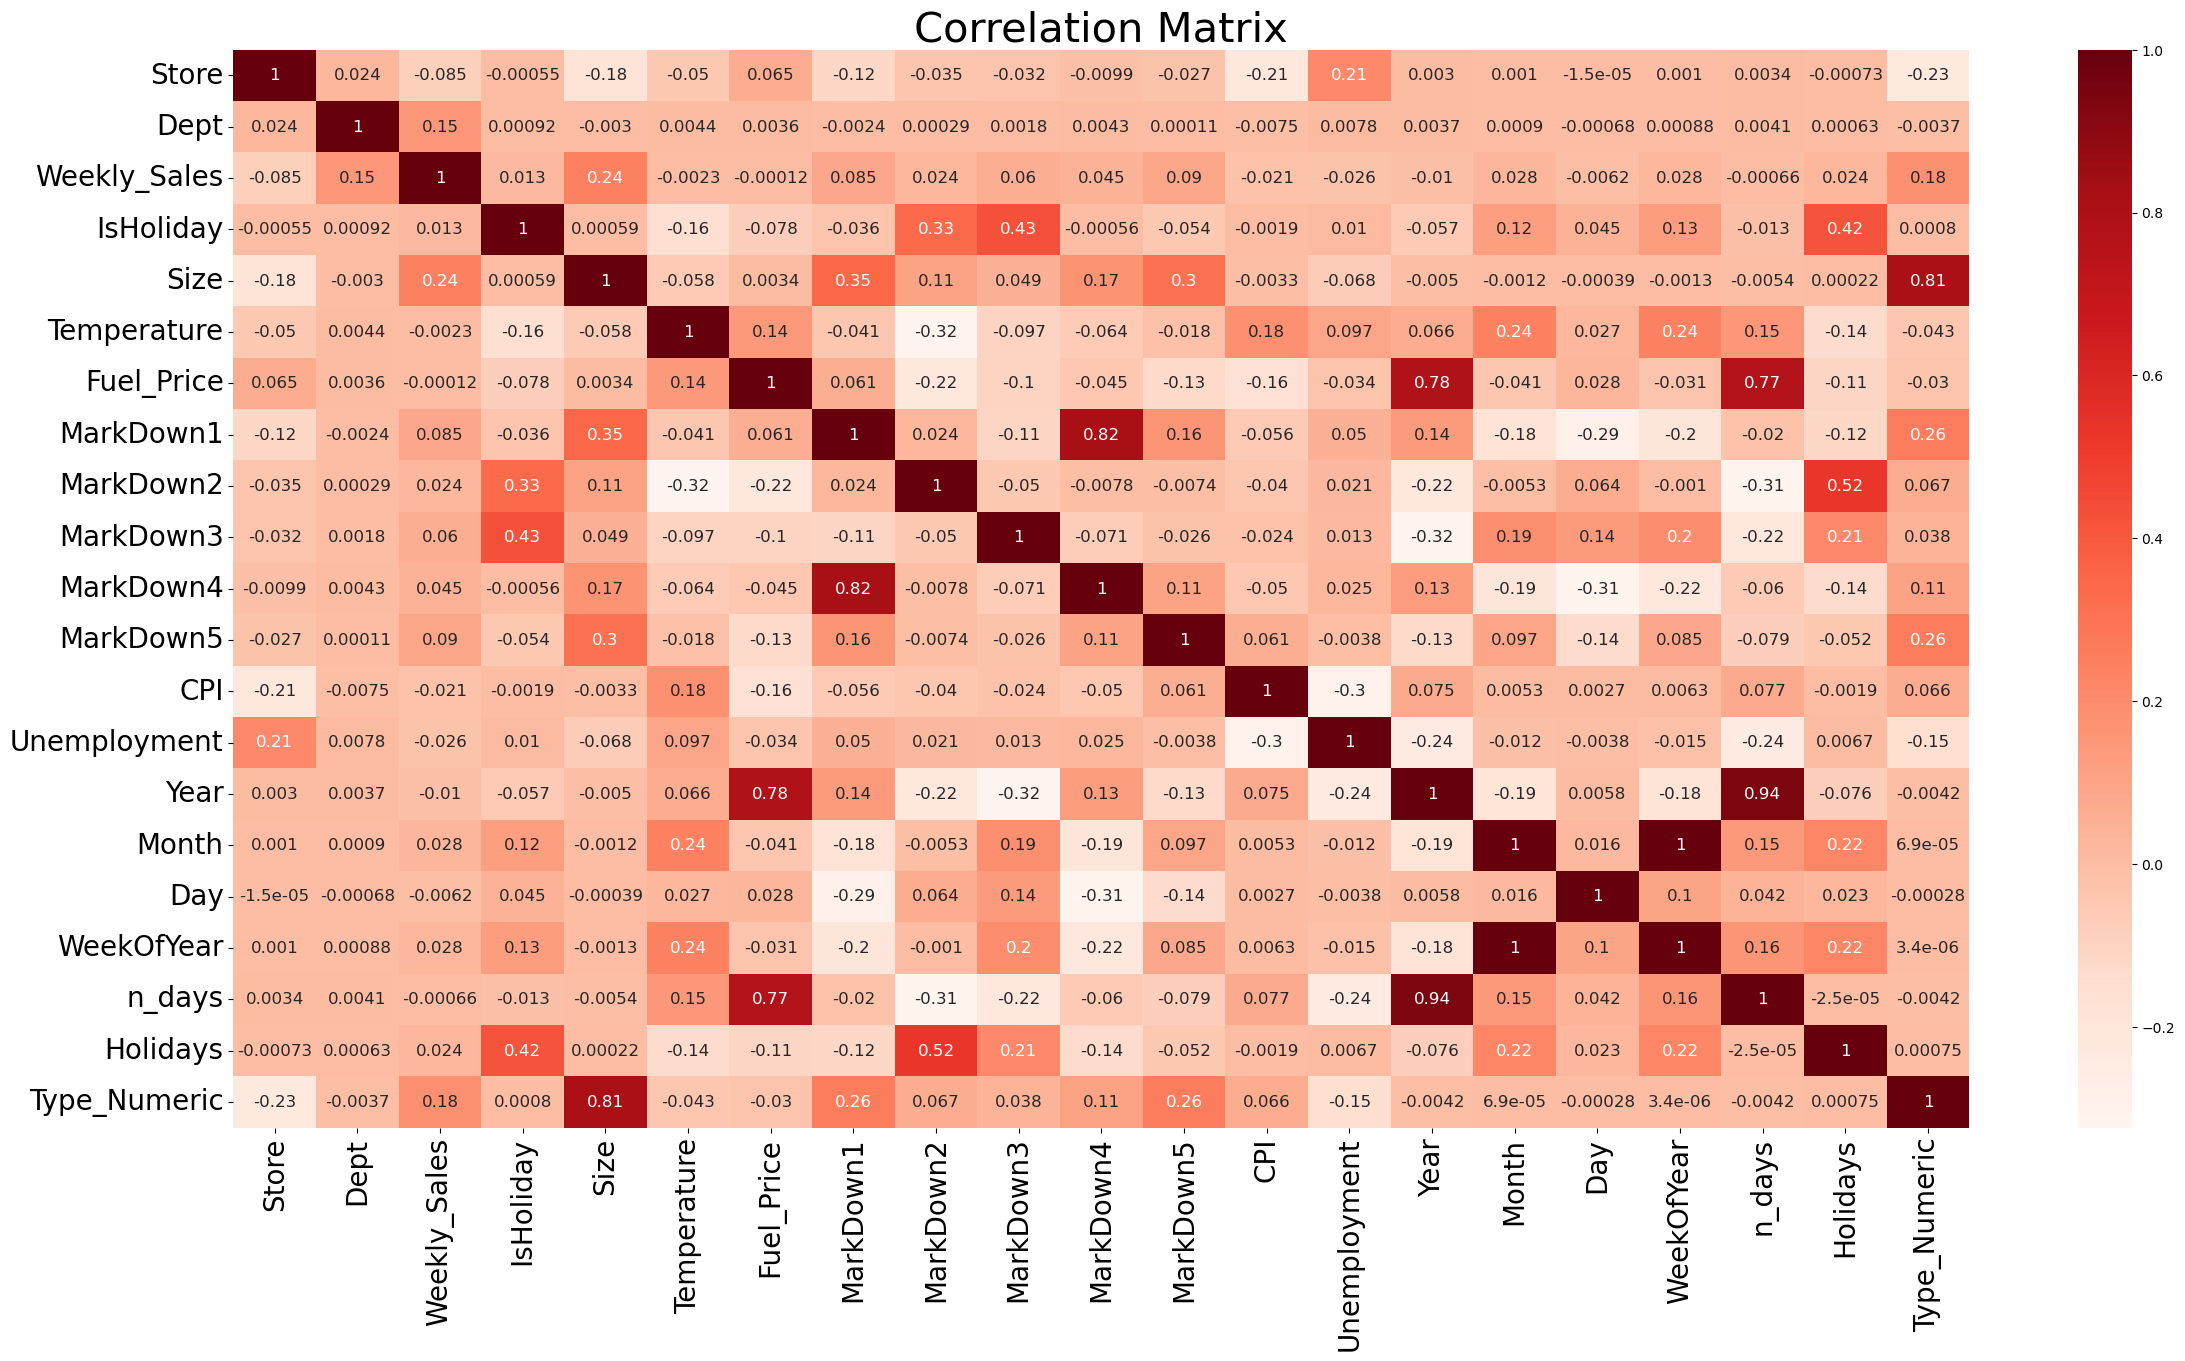

In [43]:
plt.figure(figsize=(28,14))
plt.xticks( fontsize=20)
plt.yticks( fontsize=20)

sns.heatmap(train_merged.corr(), cmap='Reds', annot=True, annot_kws={'size':12})
plt.title('Correlation Matrix', fontsize=30);

- Department, Store size and Type have moderate correlation with the weekly sales


- Markdown1-5 have very weak correlation with the weekly sales, so we will leave these columns out 


- Temperature. Fuel price, CPI and Unemployment are very weakly coorelated with the weekly sales, so these columns will also be dropped out 


- IsHoliday will be considered for the further analysis as the sales in the holiday weeks are higher than in the non-holiday weeks


- We will also leave out Month and Day as this information is already contained in the WeekOfYear

# 3. Data Preparation for Model Training

Following steps will be performed for preparing the data for the subsequent model training

- Based on the Exploratory Data Analysis and Coorelation study, the columns with weak relationship with the target column will be dropped 

 
 - Input and Target dataframes will be created 


 - Inputs will be scaled in the 0 to 1 range


 - Training and Validation datasets will be created


 - A function will be defined based on which the models performance will be measured

### check features important with random forest

In [48]:
data = train_merged.loc[:, train_merged.columns != 'Weekly_Sales']
data = data.loc[:, data.columns != 'Date']
data['Type'] = data['Type'].astype('category')
data['Type'] = data['Type'].cat.codes
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
d=imp.fit_transform(pd.concat([data['MarkDown1'],data['MarkDown2'],
                               data['MarkDown3'],data['MarkDown4'],data['MarkDown5']],axis = 1))
data['MarkDown1'] = d[:,0]
data['MarkDown2'] = d[:,1]
data['MarkDown3'] = d[:,2]
data['MarkDown4'] = d[:,3]
data['MarkDown5'] = d[:,4]
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor(n_jobs=-1, random_state=42)
clf.fit(data, train['Weekly_Sales'])

RandomForestRegressor(n_jobs=-1, random_state=42)

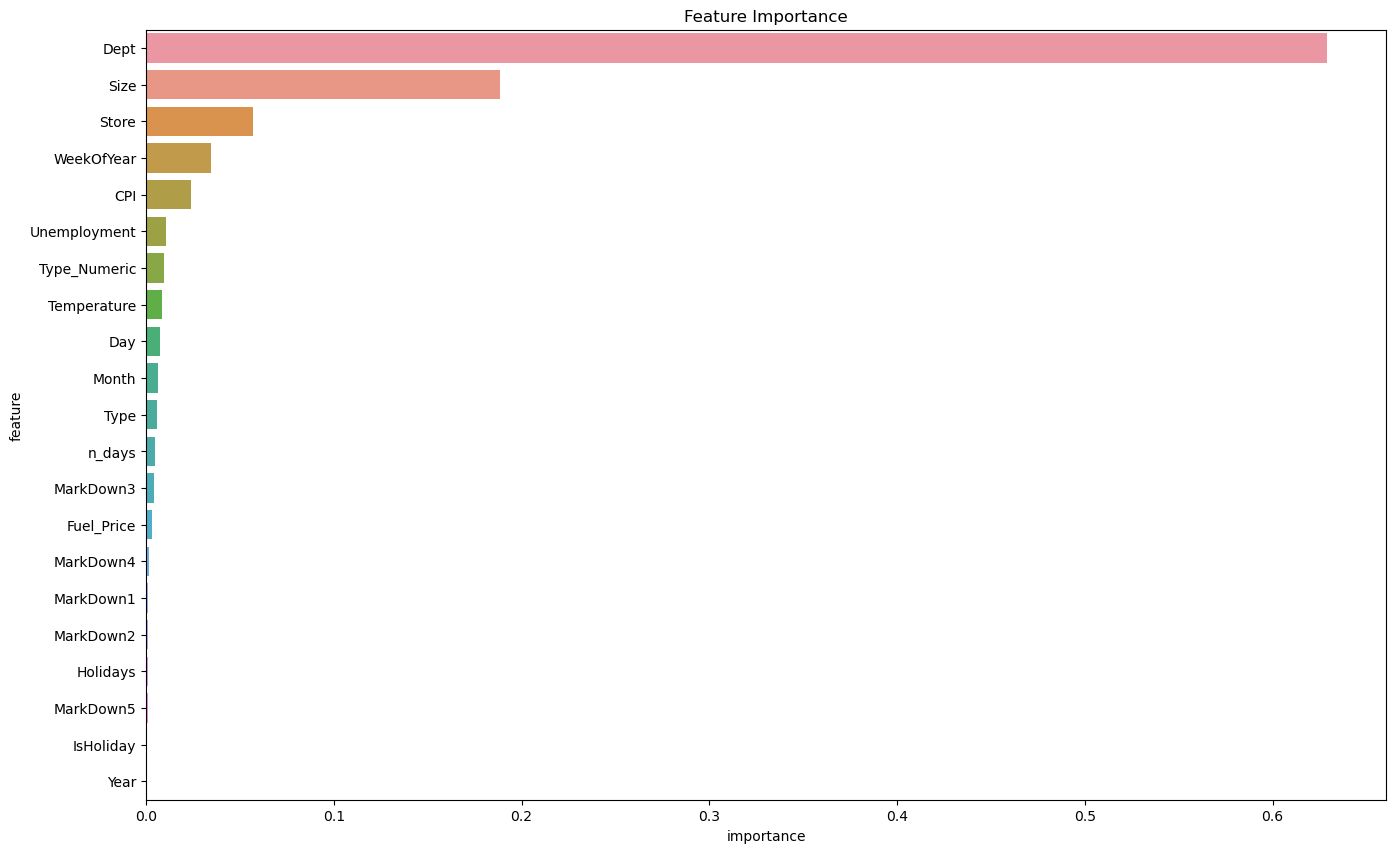

In [49]:
importance_df = pd.DataFrame({
    'feature': data.columns,
    'importance': clf.feature_importances_
}).sort_values('importance', ascending=False)
plt.figure(figsize=(16,10))
plt.title('Feature Importance')
sns.barplot(data=importance_df, x='importance', y='feature');

In [52]:
merged = train_merged.drop(['Date','Temperature','Fuel_Price', 'Type', 'MarkDown1', 'MarkDown2', 'MarkDown3',
             'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment'], axis=1)

testing_merged = test_merged.drop(['Date','Temperature','Fuel_Price', 'Type', 'MarkDown1', 'MarkDown2', 'MarkDown3',
             'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment'], axis=1)

In [53]:
merged.columns

Index(['Store', 'Dept', 'Weekly_Sales', 'IsHoliday', 'Size', 'Year', 'Month',
       'Day', 'WeekOfYear', 'n_days', 'Holidays', 'Type_Numeric'],
      dtype='object')

In [57]:
# Identify input and target columns

input_cols = merged.columns.to_list()
input_cols.remove('Weekly_Sales')
target_col = 'Weekly_Sales'

inputs_df = merged[input_cols].copy()
targets = merged[target_col].copy()

In [58]:
# Scale the values

# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler().fit(merged[input_cols])

# inputs_df[input_cols] = scaler.transform(inputs_df[input_cols])
# testing_merged[input_cols] = scaler.transform(testing_merged[input_cols])
X_train, X_test, y_train, y_test = train_test_split(inputs_df, targets, test_size=0.2)
t = StandardScaler()
t.fit(X_train)
train_data = t.transform(X_train)
test_data = t.transform(X_test)

In [60]:
merged.Holidays.value_counts()

0    341855
1     70813
2      8902
Name: Holidays, dtype: int64